In [1]:
import itertools # 是 Python 的內建模組，提供了一組用於處理迭代器的函數和工具。
                 # 它包含了各種用於高效處理迭代器的函數，可以幫助我們編寫更簡潔、高效的代碼。
import sys # 是 Python 的內建模組，提供了與 Python 解釋器和運行環境相關的功能。
# sys.path 是一個列表，包含了 Python 解釋器在導入模組時會搜尋的路徑。
# 當你使用 import 語句導入模組時 Python 會依次在 sys.path 中的路徑下尋找對應的模組文件。
sys.path.append("../ecg-classification/")
# sys.path.append("C:\\Users\\Chen_Lab01\\Documents\\GitHub/ecg-classification")
# from IPython.display import Video
# import cv2
from matplotlib import pyplot as plt
plt.style.use("ggplot") #  是 Matplotlib 庫中用於設置繪圖樣式的函數。它使用了一種名為 "ggplot" 的預定義樣式
import matplotlib
matplotlib.use("TkAgg")
                        #  該樣式模仿了 R 語言的 ggplot2 繪圖包的外觀。
# print(sys.path)
from ecg_tools.config import EcgConfig, Mode
from ecg_tools.data_loader import DatasetConfig, get_data_loaders
from ecg_tools.model import ECGformer
from ecg_tools.train import ECGClassifierTrainer



## Data

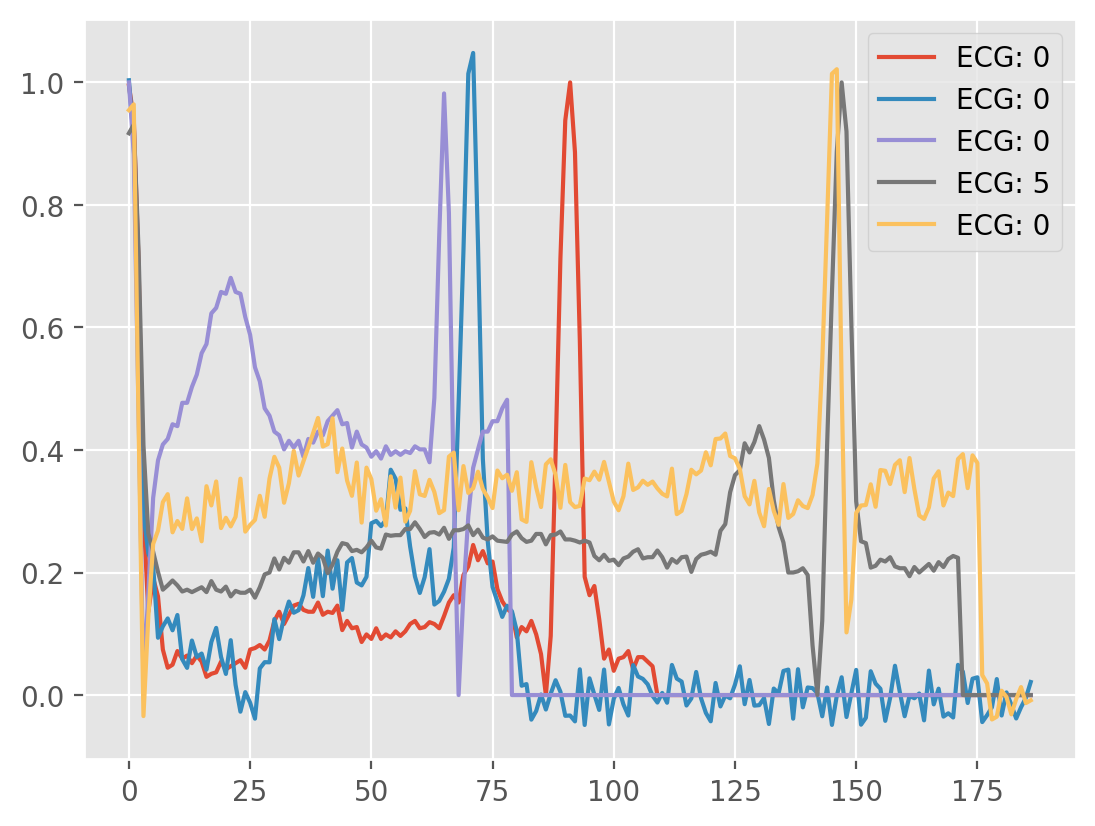

In [2]:
# 隨機抽 5 筆 ECG Data 出來觀察
NUM_EXAMPLES = 5
config = EcgConfig()
data_loaders = get_data_loaders(config.dataset)

plt.figure(1, dpi=200) # dpi 設置解析度
labels = []

for idx, data in enumerate(data_loaders[Mode.train]):
    if idx == NUM_EXAMPLES:
        break
    plt.plot(data[0][0, ...].squeeze().numpy())
    labels.append(int(data[1][0, ...].numpy()))

plt.legend([f"ECG: {label}" for label in labels])
%matplotlib inline
plt.show()

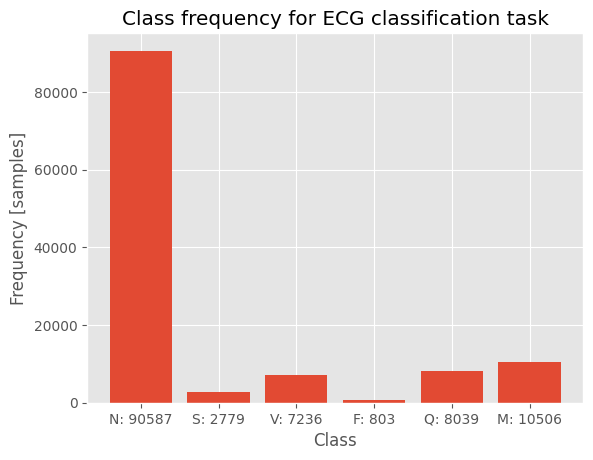

In [3]:
config = EcgConfig()
data_loaders = get_data_loaders(config.dataset)
classes = ["N", "S", "V", "F", "Q", "M"]
labels = {
    idx: 0 for idx in range(len(classes))
}

for data in itertools.chain(*list(data_loaders.values())):
    for label in data[1].numpy():
        labels[int(label)] += 1

plt.bar(range(len(classes)), list(labels.values()), tick_label=[f"{k}: {v}" for k, v in zip(classes, list(labels.values()))])
plt.title("Class frequency for ECG classification task")
plt.ylabel("Frequency [samples]")
plt.xlabel("Class")
%matplotlib inline
plt.show()

## Modeling

In [4]:
config = EcgConfig()
model = ECGformer(
    embed_size=config.model.embed_size,
    num_layers=config.model.num_layers,
    num_heads=config.model.num_heads,
    num_classes=config.model.num_classes,
    signal_length=config.model.signal_length,
    expansion=config.model.expansion,
    input_channels=config.model.input_channels
)
model
from torchinfo import summary
# input = (batch_size, signal_length, input_channels)
summary(model, input_size=(64, config.model.signal_length, 1),
       device='cpu',
       col_names=("input_size", "output_size", "num_params", "kernel_size"),
       depth=3) # depth = 3 表示只顯示到第三層
# print(model)




Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
ECGformer                                          [64, 187, 1]              [64, 6]                   36,096                    --
├─LinearEmbedding: 1-1                             [64, 187, 1]              [64, 188, 192]            192                       --
│    └─Linear: 2-1                                 [64, 187, 1]              [64, 187, 192]            384                       --
│    └─LayerNorm: 2-2                              [64, 187, 192]            [64, 187, 192]            384                       --
│    └─GELU: 2-3                                   [64, 187, 192]            [64, 187, 192]            --                        --
├─ModuleList: 1-2                                  --                        --                        --                        --
│    └─TransformerEncoderLayer: 2-4                [64, 188, 192] 

### Quantization Test

In [5]:
import torch.quantization
model(torch.randn(1, config.model.signal_length, 1)).shape

# 使用 Eager Mode Quantization
# 將 torch.nn.Linear 的參數映射到 -127~127 之間
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

quantized_model
from torchinfo import summary
summary(quantized_model, input_size=(64, config.model.signal_length, 1),
       device='cpu',
       col_names=("input_size", "output_size", "num_params", "kernel_size"),
       depth=5) # depth = 3 表示只顯示到第三層
# print(model)


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
ECGformer                                          [64, 187, 1]              [64, 6]                   36,096                    --
├─LinearEmbedding: 1-1                             [64, 187, 1]              [64, 188, 192]            192                       --
│    └─Linear: 2-1                                 [64, 187, 1]              [64, 187, 192]            --                        --
│    └─LayerNorm: 2-2                              [64, 187, 192]            [64, 187, 192]            384                       --
│    └─GELU: 2-3                                   [64, 187, 192]            [64, 187, 192]            --                        --
├─ModuleList: 1-2                                  --                        --                        --                        --
│    └─TransformerEncoderLayer: 2-4                [64, 188, 192] 

### Model ParameterTest

In [6]:
for name in quantized_model.state_dict():
   print(name)

print(quantized_model.state_dict()['encoder.0.0.block.1.queries_projection._packed_params._packed_params'])

positional_encoding
encoder.0.0.block.0.weight
encoder.0.0.block.0.bias
encoder.0.0.block.1.queries_projection.scale
encoder.0.0.block.1.queries_projection.zero_point
encoder.0.0.block.1.queries_projection._packed_params.dtype
encoder.0.0.block.1.queries_projection._packed_params._packed_params
encoder.0.0.block.1.values_projection.scale
encoder.0.0.block.1.values_projection.zero_point
encoder.0.0.block.1.values_projection._packed_params.dtype
encoder.0.0.block.1.values_projection._packed_params._packed_params
encoder.0.0.block.1.keys_projection.scale
encoder.0.0.block.1.keys_projection.zero_point
encoder.0.0.block.1.keys_projection._packed_params.dtype
encoder.0.0.block.1.keys_projection._packed_params._packed_params
encoder.0.0.block.1.final_projection.scale
encoder.0.0.block.1.final_projection.zero_point
encoder.0.0.block.1.final_projection._packed_params.dtype
encoder.0.0.block.1.final_projection._packed_params._packed_params
encoder.0.1.block.0.weight
encoder.0.1.block.0.bias
enco

### Visualize Model

In [7]:
quantized_model.eval()
inputs = torch.randn(1, 187, 1)
traced_script_module = torch.jit.trace(quantized_model, inputs)
traced_script_module.save("traced_resnet_model.pth")

# from torchviz import make_dot
# vis_graph = make_dot(quantized_model(inputs), params=dict(quantized_model.named_parameters()), show_attrs=True, show_saved=True)
# vis_graph.view()  # 会在当前目录下保存一个“Digraph.gv.pdf”文件，并在默认浏览器中打开

# import netron
# modelData = 'traced_resnet_model.pth'
# netron.start(modelData)

## Training

TRAINING: 0, loss: 0.8136364221572876. Target: [0, 0, 0, 0, 5, 0, 5, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:20<00:00, 37.06it/s] 


TRAINING Accuracy: 0.7674224376678467
[[69691     0   535    85  2031   128]
 [ 2151     0    20     1    50     1]
 [ 4454     0   450    17   856    11]
 [  605     0     2    29     4     1]
 [ 2869     0    87     1  3465     9]
 [ 7706     0   188     7   491    13]]
epoch_loss: 0.0002713025749107328


VALIDATION: 0, loss: 1.9148067235946655. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 750/750 [00:08<00:00, 90.02it/s] 


VALIDATION Accuracy: 0.8210833072662354
[[17945     0    12    78    80     2]
 [  551     0     1     2     2     0]
 [  914     0   315    64   155     0]
 [   87     0     0    75     0     0]
 [  236     0     9     2  1359     2]
 [ 1961     0    54    16    58    12]]


TRAINING: 1, loss: 1.193467617034912. Target: [0, 0, 0, 3, 1, 0, 2, 0], Prediction: [0, 0, 0, 0, 0, 0, 2, 0]: 100%|██████████| 2999/2999 [01:22<00:00, 36.28it/s]  


TRAINING Accuracy: 0.8161574602127075
[[69416   189  1181   365   856   463]
 [ 1675   396   102     7    34     9]
 [ 2338    37  2861   114   383    55]
 [  422     0    15   202     0     2]
 [ 1128    25   239     1  4962    76]
 [ 7233    56   341    35   252   488]]
epoch_loss: 0.00039795519074188466


TRAINING: 2, loss: 0.8744082450866699. Target: [0, 0, 0, 4, 2, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:18<00:00, 38.40it/s] 


TRAINING Accuracy: 0.8404989242553711
[[69130   451   917   316   513  1143]
 [ 1286   753   107     3    36    38]
 [ 1605    73  3639   147   199   125]
 [  345     8    18   266     0     4]
 [  711    34   123     0  5396   167]
 [ 6337    99   306    28   158  1477]]
epoch_loss: 0.0002915666038968556


VALIDATION: 2, loss: 0.9362711310386658. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [4, 5, 0, 0, 5, 5, 5, 0]: 100%|██████████| 750/750 [00:07<00:00, 98.11it/s]  


VALIDATION Accuracy: 0.8546666502952576
[[16628   120   119   157   219   874]
 [  247   265     4     0     3    37]
 [  234    21  1033    71    57    32]
 [   29     0     8   124     1     0]
 [   65     1     9     0  1473    60]
 [ 1009    18    27     6    52   989]]


TRAINING: 3, loss: 0.6478346586227417. Target: [0, 0, 0, 4, 0, 0, 0, 0], Prediction: [0, 0, 0, 4, 0, 0, 2, 0]: 100%|██████████| 2999/2999 [01:19<00:00, 37.54it/s] 


TRAINING Accuracy: 0.8504501581192017
[[68860   546   769   341   405  1549]
 [ 1165   874   106     5    18    55]
 [ 1358    61  3962   129   164   114]
 [  322    13    23   277     1     5]
 [  585    31    94     1  5536   184]
 [ 5744   103   274    24   153  2107]]
epoch_loss: 0.0002160168918381933


TRAINING: 4, loss: 0.3062647581100464. Target: [0, 0, 0, 0, 5, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:18<00:00, 38.38it/s] 


TRAINING Accuracy: 0.8588487505912781
[[68780   599   722   339   337  1693]
 [ 1035  1000    96     5    28    59]
 [ 1158    92  4146   130   127   135]
 [  312     5    27   292     0     5]
 [  531    25    99     1  5592   183]
 [ 5300   107   250    16   120  2612]]
epoch_loss: 0.00010212229346783808


VALIDATION: 4, loss: 0.649447500705719. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [4, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:07<00:00, 98.22it/s]   


VALIDATION Accuracy: 0.8667500019073486
[[16238   186   107    25   118  1443]
 [  159   322    11     0     2    62]
 [  145    40  1132    29    12    90]
 [   52     0    11    95     0     4]
 [   48     2     9     0  1473    76]
 [  517     8    10     1    23  1542]]


TRAINING: 5, loss: 1.1032429933547974. Target: [0, 0, 5, 0, 0, 5, 0, 0], Prediction: [0, 0, 5, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:22<00:00, 36.56it/s] 


TRAINING Accuracy: 0.8648195266723633
[[68768   554   707   378   330  1733]
 [  967  1085    88     1    21    61]
 [ 1084    81  4248   107   121   147]
 [  290     4    31   310     0     6]
 [  486    33    88     1  5653   170]
 [ 5045   105   203    28    93  2931]]
epoch_loss: 0.00036787028788089275


TRAINING: 6, loss: 0.6765686869621277. Target: [2, 0, 0, 0, 0, 0, 0, 4], Prediction: [0, 0, 0, 0, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [01:19<00:00, 37.74it/s] 


TRAINING Accuracy: 0.8697378039360046
[[68697   592   674   398   319  1790]
 [  894  1155    89     1    21    63]
 [  981    88  4325   119   134   141]
 [  276     3    22   331     0     9]
 [  439    21    83     1  5728   159]
 [ 4741   101   212    20   100  3231]]
epoch_loss: 0.00022559809501904892


VALIDATION: 6, loss: 0.5104856491088867. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:07<00:00, 97.07it/s]  


VALIDATION Accuracy: 0.9026249647140503
[[17049   141    68    40    10   809]
 [  194   330     6     0     0    26]
 [  175    26  1148    46     4    49]
 [   48     0     5   107     1     1]
 [  105     3     3     0  1433    64]
 [  485     4     7     2     7  1596]]


TRAINING: 7, loss: 0.2817075848579407. Target: [0, 0, 0, 0, 4, 0, 0, 4], Prediction: [0, 0, 0, 0, 4, 0, 0, 4]: 100%|██████████| 2999/2999 [01:19<00:00, 37.73it/s] 


TRAINING Accuracy: 0.8748749494552612
[[68778   559   615   347   286  1885]
 [  862  1218    68     2    17    56]
 [  898    71  4425   119   124   151]
 [  256     5    30   345     0     5]
 [  427    22    89     0  5744   149]
 [ 4564    79   208    19    85  3450]]
epoch_loss: 9.39338395658355e-05


TRAINING: 8, loss: 0.9481426477432251. Target: [0, 4, 4, 2, 0, 1, 5, 0], Prediction: [0, 4, 4, 2, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:18<00:00, 38.12it/s] 


TRAINING Accuracy: 0.8772820234298706
[[68745   578   591   335   272  1949]
 [  831  1246    62     1    17    66]
 [  883    87  4435   118   107   158]
 [  237     6    38   352     0     8]
 [  399    18    90     1  5791   132]
 [ 4416    95   175    22    75  3622]]
epoch_loss: 0.000316152933558928


VALIDATION: 8, loss: 0.7685487270355225. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 0]: 100%|██████████| 750/750 [00:06<00:00, 112.83it/s]   


VALIDATION Accuracy: 0.9159583449363708
[[17385    92   163   124    58   295]
 [  185   342    12     0     6    11]
 [  112    13  1249    57     3    14]
 [   27     0     8   126     1     0]
 [   69     0    19     0  1494    26]
 [  660     6    29     4    15  1387]]


TRAINING: 9, loss: 0.6189333200454712. Target: [5, 0, 0, 0, 0, 0, 5, 0], Prediction: [0, 0, 0, 0, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.66it/s] 


TRAINING Accuracy: 0.8800849914550781
[[68724   555   604   326   265  1996]
 [  797  1281    65     0    18    62]
 [  850    82  4482   108   105   161]
 [  242     1    31   361     0     6]
 [  350    17    73     0  5833   158]
 [ 4255    96   179    20    76  3779]]
epoch_loss: 0.00020637989998181766


TRAINING: 10, loss: 0.6766791939735413. Target: [0, 3, 2, 5, 0, 4, 4, 2], Prediction: [0, 3, 2, 5, 0, 4, 4, 2]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s] 


TRAINING Accuracy: 0.8833569288253784
[[68691   569   624   330   283  1973]
 [  828  1270    58     1    11    55]
 [  790    69  4522   116   118   173]
 [  232     4    30   366     0     9]
 [  357    11    87     1  5847   128]
 [ 3965    92   177    21    72  4078]]
epoch_loss: 0.00022563494297217113


VALIDATION: 10, loss: 0.6126468181610107. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 0]: 100%|██████████| 750/750 [00:06<00:00, 113.05it/s]   


VALIDATION Accuracy: 0.9303333163261414
[[17689    69    64    42    24   229]
 [  209   334     2     0     3     8]
 [  142    20  1208    50     9    19]
 [   41     0     8   112     1     0]
 [   91     0     4     0  1486    27]
 [  572     5     9     2    14  1499]]


TRAINING: 11, loss: 0.7750058174133301. Target: [0, 0, 2, 0, 5, 0, 0, 2], Prediction: [0, 0, 2, 0, 5, 0, 0, 1]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s] 


TRAINING Accuracy: 0.8864829540252686
[[68758   500   552   309   260  2091]
 [  789  1300    56     1    16    61]
 [  764    81  4577   110   103   153]
 [  227     1    44   358     0    11]
 [  357    20    74     2  5858   120]
 [ 3854    74   160    19    75  4223]]
epoch_loss: 0.00025842141294209073


TRAINING: 12, loss: 0.6023194193840027. Target: [0, 0, 0, 0, 0, 3, 0, 0], Prediction: [0, 0, 5, 0, 0, 3, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.85it/s] 


TRAINING Accuracy: 0.8870561122894287
[[68650   548   532   324   245  2171]
 [  775  1308    64     2    13    61]
 [  740    74  4606   113   107   148]
 [  232     4    37   361     0     7]
 [  324    10    76     1  5884   136]
 [ 3761    69   163    20    72  4320]]
epoch_loss: 0.0002008400864901643


VALIDATION: 12, loss: 0.6642688512802124. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 113.17it/s]   


VALIDATION Accuracy: 0.9309999942779541
[[17699    90    54    51    14   209]
 [  205   336     7     0     0     8]
 [  149    15  1192    56     7    29]
 [   33     0     6   123     0     0]
 [   82     0     5     0  1491    30]
 [  568    10     6     2    12  1503]]


TRAINING: 13, loss: 0.13446801900863647. Target: [0, 0, 0, 0, 0, 2, 0, 0], Prediction: [0, 0, 0, 0, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.84it/s]


TRAINING Accuracy: 0.8916200995445251
[[68822   521   551   304   235  2037]
 [  751  1341    57     4    13    57]
 [  731    68  4608   112    99   170]
 [  220     3    32   380     0     6]
 [  288    12    73     2  5938   118]
 [ 3628    69   152    13    65  4478]]
epoch_loss: 4.4837618875837436e-05


TRAINING: 14, loss: 0.2778073847293854. Target: [0, 0, 5, 0, 0, 0, 0, 0], Prediction: [0, 0, 5, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s] 


TRAINING Accuracy: 0.8928705453872681
[[68766   482   547   321   242  2112]
 [  759  1329    61     2     8    64]
 [  745    57  4619   109    96   162]
 [  209     4    37   382     1     8]
 [  321     8    66     0  5904   132]
 [ 3394    78   149    25    72  4687]]
epoch_loss: 9.263333935624721e-05


VALIDATION: 14, loss: 0.6593853831291199. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 113.15it/s]  


VALIDATION Accuracy: 0.9324583411216736
[[17843    35    37    14    16   172]
 [  219   325     4     0     1     7]
 [  193    33  1166    35     7    14]
 [   63     0     7    91     1     0]
 [   75     0     5     0  1511    17]
 [  633     0     5     0    20  1443]]


TRAINING: 15, loss: 0.21902942657470703. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.84it/s]


TRAINING Accuracy: 0.8940688371658325
[[68631   533   539   331   240  2196]
 [  740  1351    50     0    11    71]
 [  676    57  4719   103    75   158]
 [  214     2    41   376     1     7]
 [  290    10    60     1  5949   121]
 [ 3325    70   142    24    68  4776]]
epoch_loss: 7.303415357609438e-05


TRAINING: 16, loss: 0.13619253039360046. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 3, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.85it/s]


TRAINING Accuracy: 0.8968406319618225
[[68782   502   547   290   233  2116]
 [  742  1353    49     0    12    67]
 [  693    58  4686   103    79   169]
 [  206     2    41   386     0     6]
 [  286     7    61     0  5956   121]
 [ 3188    80   137    18    77  4905]]
epoch_loss: 4.541264768042696e-05


VALIDATION: 16, loss: 0.7619318962097168. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 0, 0]: 100%|██████████| 750/750 [00:06<00:00, 112.93it/s]   


VALIDATION Accuracy: 0.9301666617393494
[[17617   184   127    77    24    88]
 [  167   371    12     0     1     5]
 [  105    10  1280    38     5    10]
 [   29     1    10   122     0     0]
 [   73     1     8     0  1514    12]
 [  612    18    25     2    24  1420]]


TRAINING: 17, loss: 0.17923662066459656. Target: [0, 2, 0, 5, 0, 0, 0, 0], Prediction: [0, 2, 0, 5, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.83it/s] 


TRAINING Accuracy: 0.8991851210594177
[[68750   535   502   288   236  2159]
 [  737  1371    42     1    11    61]
 [  687    54  4721    98    88   140]
 [  195     4    39   396     0     7]
 [  260    10    70     0  5974   117]
 [ 3057    66   126    18    57  5081]]
epoch_loss: 5.976546204221292e-05


TRAINING: 18, loss: 0.39038947224617004. Target: [0, 0, 4, 0, 5, 5, 4, 5], Prediction: [0, 0, 4, 0, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s]


TRAINING Accuracy: 0.9002479910850525
[[68867   473   542   258   229  2101]
 [  713  1383    54     1    12    60]
 [  672    52  4711   108    83   162]
 [  181     1    36   411     2    10]
 [  282    12    59     0  5963   115]
 [ 3063    59   133    23    67  5060]]
epoch_loss: 0.0001301732151537746


VALIDATION: 18, loss: 0.21862371265888214. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.83it/s]  


VALIDATION Accuracy: 0.9397083520889282
[[17530    37    66    21    36   427]
 [  195   333     9     0     1    18]
 [  105     4  1263    29    12    35]
 [   38     0    13   109     0     2]
 [   38     0     4     0  1538    28]
 [  302     4     4     0    11  1780]]


TRAINING: 19, loss: 0.2276914417743683. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 5, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.83it/s] 


TRAINING Accuracy: 0.9025404453277588
[[68868   489   482   288   236  2107]
 [  713  1372    55     1    14    68]
 [  644    58  4763   105    69   149]
 [  185     3    42   403     0     8]
 [  260    11    59     0  5980   121]
 [ 2908    61   112    23    72  5229]]
epoch_loss: 7.592245474303711e-05


TRAINING: 20, loss: 0.43063491582870483. Target: [0, 0, 5, 0, 0, 0, 5, 2], Prediction: [0, 0, 0, 0, 0, 0, 2, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s]


TRAINING Accuracy: 0.9047390818595886
[[68884   511   485   272   221  2097]
 [  674  1421    51     2    12    63]
 [  643    52  4749   107    73   164]
 [  180     3    39   412     1     6]
 [  260     4    57     0  5989   121]
 [ 2753    72   126    21    62  5371]]
epoch_loss: 0.00014359283622164215


VALIDATION: 20, loss: 0.44066745042800903. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.79it/s]  


VALIDATION Accuracy: 0.9399166703224182
[[17594   152   118    15    28   210]
 [  170   365    10     0     1    10]
 [  103    14  1279    25     5    22]
 [   32     3    16   109     0     2]
 [   43     1    10     0  1547     7]
 [  385    11    12     1    28  1664]]


TRAINING: 21, loss: 0.2626040577888489. Target: [0, 0, 4, 5, 0, 2, 4, 5], Prediction: [0, 0, 4, 0, 0, 2, 4, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.84it/s]  


TRAINING Accuracy: 0.9049683213233948
[[68810   509   492   283   238  2138]
 [  696  1414    42     1     8    62]
 [  626    57  4802    88    68   147]
 [  180     3    38   412     0     8]
 [  257     7    52     0  6014   101]
 [ 2739    68   115    20    67  5396]]
epoch_loss: 8.756387388757883e-05


TRAINING: 22, loss: 0.16254650056362152. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9064062833786011
[[68846   547   513   259   225  2080]
 [  677  1425    45     1    12    63]
 [  591    58  4810   111    74   144]
 [  175     2    38   417     0     9]
 [  270     8    58     0  6000    95]
 [ 2669    62   107    14    65  5488]]
epoch_loss: 5.420023359907353e-05


VALIDATION: 22, loss: 0.3243389427661896. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.86it/s]    


VALIDATION Accuracy: 0.9417083263397217
[[17557    91    31    70    46   322]
 [  187   356     3     0     2     8]
 [  131     9  1208    63    13    24]
 [   23     0     5   130     0     4]
 [   39     1     5     0  1547    16]
 [  260     8     2     3    25  1803]]


TRAINING: 23, loss: 0.22899229824543. Target: [0, 2, 0, 3, 0, 0, 4, 0], Prediction: [0, 2, 0, 0, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.85it/s]    


TRAINING Accuracy: 0.9090633988380432
[[68967   490   498   265   195  2055]
 [  686  1422    43     2    10    60]
 [  582    50  4822   109    74   151]
 [  174     3    38   416     1     9]
 [  237     9    55     0  6027   103]
 [ 2589    57   109    14    49  5587]]
epoch_loss: 7.635621815452817e-05


TRAINING: 24, loss: 0.13281740248203278. Target: [5, 0, 0, 0, 0, 0, 1, 0], Prediction: [5, 0, 0, 0, 0, 0, 1, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s]


TRAINING Accuracy: 0.9099699854850769
[[68905   543   457   273   207  2085]
 [  636  1457    48     2    16    64]
 [  558    51  4858    96    67   158]
 [  187     4    36   404     0    10]
 [  247     6    57     0  6015   106]
 [ 2458    69   105    16    68  5689]]
epoch_loss: 4.4287229903978916e-05


VALIDATION: 24, loss: 0.48310863971710205. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.82it/s]  


VALIDATION Accuracy: 0.9485416412353516
[[17709    91    89    24    40   164]
 [  174   368     9     0     1     4]
 [   79     8  1311    32     5    13]
 [   29     0    14   116     0     3]
 [   35     0     8     0  1557     8]
 [  348     9    12     0    28  1704]]


TRAINING: 25, loss: 0.7773283123970032. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s] 


TRAINING Accuracy: 0.9117101430892944
[[68956   547   456   255   200  2056]
 [  659  1457    44     3    12    48]
 [  566    52  4860   102    67   141]
 [  181     2    37   412     0     9]
 [  230    10    60     2  6026   103]
 [ 2387    50   100    17    67  5784]]
epoch_loss: 0.0002591958360776936


TRAINING: 26, loss: 0.10575023293495178. Target: [0, 0, 0, 0, 0, 0, 0, 2], Prediction: [0, 0, 0, 0, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s] 


TRAINING Accuracy: 0.9140233993530273
[[69044   503   471   251   177  2024]
 [  642  1469    39     0    15    58]
 [  551    39  4910    98    59   131]
 [  161     2    41   427     3     7]
 [  218     7    54     1  6050   101]
 [ 2363    46   110    10    59  5817]]
epoch_loss: 3.5261831588846876e-05


VALIDATION: 26, loss: 0.36898916959762573. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 0, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.85it/s]  


VALIDATION Accuracy: 0.9495416283607483
[[17660   101    87    27     9   233]
 [  171   369     9     0     1     6]
 [   74    11  1315    25     1    22]
 [   28     0    21   111     0     2]
 [   48     0    10     0  1528    22]
 [  267     9    11     1     7  1806]]


TRAINING: 27, loss: 0.5151392221450806. Target: [4, 5, 2, 0, 0, 0, 4, 0], Prediction: [0, 0, 0, 0, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s]  


TRAINING Accuracy: 0.9151904582977295
[[69086   483   450   250   189  2012]
 [  629  1484    39     0    12    59]
 [  503    59  4945    95    69   117]
 [  164     3    42   423     0     9]
 [  231     5    44     0  6062    89]
 [ 2346    65    93    12    60  5829]]
epoch_loss: 0.00017177033082530196


TRAINING: 28, loss: 0.10549703985452652. Target: [5, 0, 0, 0, 0, 0, 4, 0], Prediction: [5, 0, 0, 0, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.83it/s] 


TRAINING Accuracy: 0.9162220358848572
[[69094   509   448   233   182  2004]
 [  625  1497    33     1    13    54]
 [  527    55  4924    90    66   126]
 [  161     3    41   430     2     4]
 [  221     8    64     1  6052    85]
 [ 2252    63    94    13    52  5931]]
epoch_loss: 3.517740575342665e-05


VALIDATION: 28, loss: 0.1766335368156433. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.94it/s]   


VALIDATION Accuracy: 0.9400416612625122
[[17291   167    66    29    13   551]
 [  142   386    11     0     1    16]
 [   76    17  1289    41     1    24]
 [   22     0    11   124     0     5]
 [   34     3     6     0  1540    25]
 [  153     5     4     0     8  1931]]


TRAINING: 29, loss: 0.221257746219635. Target: [0, 4, 0, 0, 0, 0, 0, 0], Prediction: [0, 4, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s]   


TRAINING Accuracy: 0.9177433848381042
[[69111   535   438   276   206  1904]
 [  623  1485    34     1    13    67]
 [  514    48  4951   102    59   114]
 [  156     3    43   431     1     7]
 [  241     8    50     0  6049    83]
 [ 2144    63    90    12    49  6047]]
epoch_loss: 7.37771744646999e-05


TRAINING: 30, loss: 0.17422129213809967. Target: [0, 0, 0, 0, 0, 5, 0, 5], Prediction: [0, 0, 0, 0, 0, 5, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s] 


TRAINING Accuracy: 0.9177746772766113
[[69094   533   423   266   189  1965]
 [  627  1490    36     0     8    62]
 [  476    57  4962   100    60   133]
 [  166     1    35   430     0     9]
 [  220     7    55     0  6074    75]
 [ 2155    56    96    16    55  6027]]
epoch_loss: 5.809312842217395e-05


VALIDATION: 30, loss: 0.3697044253349304. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.96it/s]   


VALIDATION Accuracy: 0.9512082934379578
[[17683   105    79    63    28   159]
 [  160   381     7     0     1     7]
 [   75    10  1298    41     3    21]
 [   18     0    10   132     0     2]
 [   35     1     6     0  1551    15]
 [  291     6     7     2    11  1784]]


TRAINING: 31, loss: 0.8395867943763733. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]  


TRAINING Accuracy: 0.9200567007064819
[[69206   538   414   233   186  1893]
 [  610  1506    44     1     7    55]
 [  504    49  4953    99    57   126]
 [  145     2    44   442     0     8]
 [  221    11    46     2  6075    76]
 [ 2071    50    93    12    65  6114]]
epoch_loss: 0.00027995558331989773


TRAINING: 32, loss: 1.2015339136123657. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.83it/s]  


TRAINING Accuracy: 0.9213383793830872
[[69254   542   408   229   192  1845]
 [  613  1515    39     1     9    46]
 [  470    46  4985    89    73   125]
 [  170     2    45   418     0     6]
 [  229     6    49     0  6071    76]
 [ 1999    52    96    18    64  6176]]
epoch_loss: 0.00040064485282172916


VALIDATION: 32, loss: 0.19244368374347687. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.92it/s]   


VALIDATION Accuracy: 0.9481666684150696
[[17470   155   139    42    18   293]
 [  138   388    17     0     1    12]
 [   54    14  1341    25     4    10]
 [   21     0    18   121     0     2]
 [   29     2     9     0  1555    13]
 [  176     8    21     1    14  1881]]


TRAINING: 33, loss: 0.14219973981380463. Target: [5, 0, 0, 0, 2, 0, 0, 2], Prediction: [5, 0, 1, 0, 2, 0, 0, 2]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s] 


TRAINING Accuracy: 0.9216301441192627
[[69195   520   435   228   189  1903]
 [  596  1518    41     1    10    57]
 [  489    50  4982    92    58   117]
 [  148     4    42   442     0     5]
 [  215     5    51     0  6078    82]
 [ 1958    60    82    12    61  6232]]
epoch_loss: 4.74157185107718e-05


TRAINING: 34, loss: 0.25141674280166626. Target: [1, 0, 4, 0, 5, 0, 0, 0], Prediction: [1, 0, 4, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s] 


TRAINING Accuracy: 0.9234536290168762
[[69311   527   412   238   182  1800]
 [  582  1535    40     0    13    53]
 [  472    36  5007    93    60   120]
 [  150     1    48   430     1    11]
 [  200     6    56     0  6079    90]
 [ 1918    53    95    17    62  6260]]
epoch_loss: 8.383352544236954e-05


VALIDATION: 34, loss: 0.3095651865005493. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 113.06it/s]    


VALIDATION Accuracy: 0.9490000009536743
[[17542   125   183    25    54   188]
 [  162   374    15     0     1     4]
 [   57    16  1329    26     3    17]
 [   25     0    16   118     1     2]
 [   22     0     7     0  1567    12]
 [  214    10    11     1    19  1846]]


TRAINING: 35, loss: 0.33286798000335693. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s] 


TRAINING Accuracy: 0.924089252948761
[[69288   517   452   246   166  1801]
 [  590  1531    34     0    11    57]
 [  446    45  5007    99    58   133]
 [  149     5    45   438     0     4]
 [  198     7    42     1  6100    83]
 [ 1896    55    79     6    50  6319]]
epoch_loss: 0.00011099299099811835


TRAINING: 36, loss: 0.30505645275115967. Target: [0, 0, 0, 5, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s] 


TRAINING Accuracy: 0.9252458810806274
[[69325   517   404   222   210  1792]
 [  565  1553    42     1    14    48]
 [  447    49  5029    90    56   117]
 [  142     1    50   443     0     5]
 [  198    13    44     1  6091    84]
 [ 1862    47    75    19    49  6353]]
epoch_loss: 0.00010171939071395787


VALIDATION: 36, loss: 0.2092999815940857. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.84it/s]    


VALIDATION Accuracy: 0.953624963760376
[[17717   121    31    10    27   211]
 [  153   388     5     0     2     8]
 [  113    15  1238    38    18    26]
 [   31     0     8   119     1     3]
 [   35     2     2     0  1553    16]
 [  212     4     1     0    12  1872]]


TRAINING: 37, loss: 0.08751919865608215. Target: [0, 5, 0, 0, 4, 0, 0, 5], Prediction: [0, 5, 0, 0, 4, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s] 


TRAINING Accuracy: 0.9262670874595642
[[69336   528   406   240   166  1794]
 [  560  1568    42     0    12    41]
 [  461    44  5024    90    50   119]
 [  143     1    43   449     0     5]
 [  188     8    38     1  6121    75]
 [ 1826    62    77    11    35  6394]]
epoch_loss: 2.918279381663293e-05


TRAINING: 38, loss: 0.2130558043718338. Target: [0, 5, 0, 0, 2, 5, 0, 0], Prediction: [0, 5, 0, 0, 2, 5, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.73it/s]  


TRAINING Accuracy: 0.9244956374168396
[[69223   562   426   243   195  1821]
 [  583  1527    43     1    10    59]
 [  477    46  4994    91    68   112]
 [  147     2    38   445     1     8]
 [  197     6    50     0  6099    79]
 [ 1763    72    89     7    40  6434]]
epoch_loss: 7.104228221801727e-05


VALIDATION: 38, loss: 0.38575637340545654. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.98it/s] 


VALIDATION Accuracy: 0.9504583477973938
[[17701   176    73    22     5   140]
 [  144   401     8     0     1     2]
 [   87    12  1290    37     1    21]
 [   33     0     6   122     0     1]
 [   68     2    11     0  1509    18]
 [  287    19     3     0     4  1788]]


TRAINING: 39, loss: 0.24216943979263306. Target: [0, 2, 0, 0, 0, 0, 4, 0], Prediction: [0, 2, 0, 0, 0, 3, 4, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9256835579872131
[[69300   542   398   239   181  1810]
 [  577  1547    35     0    10    54]
 [  435    49  5051    93    60   100]
 [  143     2    46   441     0     9]
 [  198    12    46     0  6096    79]
 [ 1812    50    81    12    49  6401]]
epoch_loss: 8.075006328530612e-05


TRAINING: 40, loss: 0.44625818729400635. Target: [0, 0, 0, 0, 2, 0, 0, 0], Prediction: [0, 0, 0, 0, 2, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s] 


TRAINING Accuracy: 0.9290909171104431
[[69458   527   432   219   175  1659]
 [  564  1571    30     0    11    47]
 [  426    42  5055    91    56   118]
 [  148     2    38   443     0    10]
 [  195     5    37     2  6114    78]
 [ 1676    59    91     8    49  6522]]
epoch_loss: 0.00014880232987462698


VALIDATION: 40, loss: 0.27647554874420166. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 113.08it/s]  


VALIDATION Accuracy: 0.9541666507720947
[[17626   195    66    43    12   175]
 [  132   405    12     0     2     5]
 [   67     9  1316    39     1    16]
 [   22     0     8   130     1     1]
 [   41     4     9     0  1539    15]
 [  183    13     7     4    10  1884]]


TRAINING: 41, loss: 0.22669059038162231. Target: [1, 0, 0, 0, 0, 2, 0, 4], Prediction: [1, 0, 0, 0, 0, 2, 0, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s] 


TRAINING Accuracy: 0.9291951656341553
[[69417   544   376   212   164  1757]
 [  563  1568    37     2    14    39]
 [  437    52  5070    89    47    93]
 [  147     0    47   440     0     7]
 [  189     9    39     0  6128    66]
 [ 1671    51    77    16    40  6550]]
epoch_loss: 7.558872636933055e-05


TRAINING: 42, loss: 0.1996488869190216. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s]  


TRAINING Accuracy: 0.9296640157699585
[[69462   543   390   228   171  1676]
 [  549  1570    38     3     6    57]
 [  447    52  5035   100    51   103]
 [  146     2    41   438     0    14]
 [  185     9    44     1  6117    75]
 [ 1619    60    72    17    41  6596]]
epoch_loss: 6.657181957953371e-05


VALIDATION: 42, loss: 0.2920107841491699. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 113.04it/s]    


VALIDATION Accuracy: 0.9575833082199097
[[17696   131    99    37    15   139]
 [  145   394     9     0     1     7]
 [   61    13  1321    36     2    15]
 [   20     0    13   125     0     4]
 [   33     1     9     0  1556     9]
 [  177    11    12     1    10  1890]]


TRAINING: 43, loss: 0.06314703077077866. Target: [0, 0, 4, 0, 0, 0, 0, 0], Prediction: [0, 0, 4, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.76it/s] 


TRAINING Accuracy: 0.929716169834137
[[69385   557   408   230   181  1709]
 [  549  1586    25     0     9    54]
 [  411    56  5086    90    46    99]
 [  134     1    39   455     0    12]
 [  177    10    42     0  6135    67]
 [ 1659    42    85     5    38  6576]]
epoch_loss: 2.10560289332373e-05


TRAINING: 44, loss: 0.6326784491539001. Target: [0, 0, 5, 5, 2, 5, 0, 0], Prediction: [0, 0, 5, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s]  


TRAINING Accuracy: 0.9312270879745483
[[69498   520   396   213   160  1683]
 [  534  1594    33     2    12    48]
 [  424    50  5086    89    58    81]
 [  127     2    45   460     2     5]
 [  197     7    51     0  6111    65]
 [ 1609    54    67    10    46  6619]]
epoch_loss: 0.00021096313743044354


VALIDATION: 44, loss: 0.1128513440489769. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 113.01it/s]    


VALIDATION Accuracy: 0.9548749923706055
[[17559   129   158    33    51   187]
 [  124   396    22     0     4    10]
 [   39     4  1364    24     4    13]
 [   23     0    23   114     0     2]
 [   19     1    11     0  1570     7]
 [  146     9    12     3    17  1914]]


TRAINING: 45, loss: 0.20965519547462463. Target: [0, 0, 0, 0, 0, 1, 0, 0], Prediction: [0, 5, 0, 0, 0, 1, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9310811758041382
[[69487   537   396   234   172  1644]
 [  539  1594    31     1     7    51]
 [  445    34  5075    81    51   102]
 [  133     2    42   454     0    10]
 [  170     4    49     0  6130    78]
 [ 1605    51    73    14    48  6614]]
epoch_loss: 6.990836794752405e-05


TRAINING: 46, loss: 0.17151705920696259. Target: [0, 0, 4, 0, 0, 0, 0, 5], Prediction: [0, 0, 4, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.933196485042572
[[69533   534   412   209   185  1597]
 [  526  1606    39     1     8    43]
 [  399    52  5103    77    54   103]
 [  139     2    36   458     0     6]
 [  172     6    46     1  6136    70]
 [ 1501    51    69    14    49  6721]]
epoch_loss: 5.71914168746124e-05


VALIDATION: 46, loss: 0.2183150202035904. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.78it/s]    


VALIDATION Accuracy: 0.9506666660308838
[[17457   355    84    41    24   156]
 [  111   423    10     1     2     9]
 [   50    17  1328    37     2    14]
 [   22     0    12   127     0     1]
 [   25     2     8     0  1561    12]
 [  147    13     7     0    14  1920]]


TRAINING: 47, loss: 0.17661212384700775. Target: [0, 0, 5, 0, 5, 5, 0, 4], Prediction: [0, 0, 5, 0, 5, 0, 0, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9336133003234863
[[69567   554   374   211   153  1611]
 [  544  1580    35     2     8    54]
 [  403    47  5098    89    49   102]
 [  122     0    46   468     0     5]
 [  151     7    47     0  6150    76]
 [ 1492    61    68     8    42  6734]]
epoch_loss: 5.8890338061689814e-05


TRAINING: 48, loss: 0.4686283469200134. Target: [0, 0, 0, 3, 0, 0, 0, 0], Prediction: [0, 0, 0, 2, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s]  


TRAINING Accuracy: 0.9344364404678345
[[69604   511   380   191   165  1619]
 [  523  1603    30     2     9    56]
 [  417    47  5102    86    50    86]
 [  132     1    48   454     0     6]
 [  171     4    43     0  6157    56]
 [ 1483    53    63     9    41  6756]]
epoch_loss: 0.00015626153615205517


VALIDATION: 48, loss: 0.4199090003967285. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 113.06it/s]    


VALIDATION Accuracy: 0.9622499942779541
[[17851    32    88    23    27    96]
 [  179   351    14     0     3     9]
 [   53     4  1355    19     3    14]
 [   26     0    20   116     0     0]
 [   25     0    10     0  1567     6]
 [  220     0     8     1    18  1854]]


TRAINING: 49, loss: 0.19147059321403503. Target: [0, 0, 0, 0, 0, 4, 0, 0], Prediction: [0, 0, 0, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s] 


TRAINING Accuracy: 0.9337904453277588
[[69549   513   415   232   178  1583]
 [  522  1617    37     0     7    40]
 [  408    45  5107    69    53   106]
 [  132     2    46   453     1     7]
 [  167     8    44     0  6147    65]
 [ 1488    42    66    19    49  6741]]
epoch_loss: 6.38448126755702e-05


TRAINING: 50, loss: 0.17553114891052246. Target: [0, 0, 0, 0, 3, 0, 0, 0], Prediction: [0, 0, 0, 0, 3, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9348741173744202
[[69618   550   393   213   174  1522]
 [  514  1610    45     0     9    45]
 [  403    46  5103    86    49   101]
 [  124     2    46   459     1     9]
 [  189     6    40     0  6132    64]
 [ 1432    51    65    12    49  6796]]
epoch_loss: 5.852989293448565e-05


VALIDATION: 50, loss: 0.15681958198547363. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.99it/s]   


VALIDATION Accuracy: 0.9610833525657654
[[17701    94    64    35    28   195]
 [  139   396    10     1     2     8]
 [   56     5  1321    40     8    18]
 [   21     0     8   132     0     1]
 [   24     1     8     1  1558    16]
 [  122     4     4     2    11  1958]]


TRAINING: 51, loss: 0.4734603464603424. Target: [0, 0, 0, 0, 0, 0, 0, 5], Prediction: [0, 0, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]  


TRAINING Accuracy: 0.9351242184638977
[[69581   552   404   196   166  1571]
 [  529  1613    27     2     7    45]
 [  396    47  5114    77    47   107]
 [  129     2    42   457     1    10]
 [  164     8    42     0  6150    67]
 [ 1409    47    67    12    43  6827]]
epoch_loss: 0.0001578727397333586


TRAINING: 52, loss: 0.3704591989517212. Target: [0, 0, 0, 2, 1, 0, 5, 0], Prediction: [0, 0, 0, 0, 1, 0, 5, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]  


TRAINING Accuracy: 0.9363120794296265
[[69611   511   354   255   179  1560]
 [  502  1625    37     0     6    53]
 [  382    45  5145    84    40    92]
 [  128     2    39   464     1     7]
 [  167     8    41     1  6153    61]
 [ 1393    55    55    10    34  6858]]
epoch_loss: 0.00012352757550907677


VALIDATION: 52, loss: 0.23679597675800323. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.90it/s]  


VALIDATION Accuracy: 0.9602916836738586
[[17803   141    44     8    10   111]
 [  139   405     8     0     2     2]
 [   66    11  1329    18     9    15]
 [   33     0    22   105     0     2]
 [   45     3     6     0  1542    12]
 [  210    13     5     1     9  1863]]


TRAINING: 53, loss: 0.23231592774391174. Target: [0, 0, 0, 0, 0, 0, 0, 5], Prediction: [0, 0, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s] 


TRAINING Accuracy: 0.9364475607872009
[[69621   552   392   201   155  1549]
 [  490  1641    34     0    10    48]
 [  391    34  5142    78    52    91]
 [  123     1    36   471     0    10]
 [  159    12    34     1  6158    67]
 [ 1409    42    63     6    49  6836]]
epoch_loss: 7.746446406932702e-05


TRAINING: 54, loss: 0.102633997797966. Target: [2, 0, 2, 4, 0, 0, 0, 0], Prediction: [2, 0, 2, 4, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s]   


TRAINING Accuracy: 0.9354472160339355
[[69559   538   390   242   177  1564]
 [  488  1635    32     2     6    60]
 [  383    45  5127    84    58    91]
 [  129     2    45   458     0     7]
 [  168     8    41     0  6151    63]
 [ 1383    61    60    10    48  6843]]
epoch_loss: 3.4222740179381794e-05


VALIDATION: 54, loss: 0.40610191226005554. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.92it/s]  


VALIDATION Accuracy: 0.9577916860580444
[[17789   177    76     9     8    58]
 [  131   415     9     0     1     0]
 [   68     8  1328    32     2    10]
 [   34     0    12   115     0     1]
 [   45     0     9     0  1545     9]
 [  264    25     7     2     8  1795]]


TRAINING: 55, loss: 0.44662633538246155. Target: [4, 0, 0, 0, 2, 5, 0, 0], Prediction: [4, 0, 0, 0, 2, 5, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.72it/s] 


TRAINING Accuracy: 0.9381981492042542
[[69773   509   367   201   134  1486]
 [  502  1628    41     0     8    44]
 [  402    42  5126    72    54    92]
 [  117     3    45   471     0     5]
 [  164     6    30     0  6168    63]
 [ 1352    56    67    14    45  6871]]
epoch_loss: 0.00014892508682309488


TRAINING: 56, loss: 0.3038161098957062. Target: [0, 0, 0, 0, 4, 0, 0, 0], Prediction: [0, 0, 0, 0, 4, 0, 4, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.76it/s]  


TRAINING Accuracy: 0.9385003447532654
[[69724   539   383   219   164  1441]
 [  487  1642    34     0    11    49]
 [  386    38  5152    75    44    93]
 [  118     3    39   475     0     6]
 [  163     3    34     1  6171    59]
 [ 1333    39    69    11    51  6902]]
epoch_loss: 0.00010130580523364661


VALIDATION: 56, loss: 0.18007874488830566. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.79it/s]   


VALIDATION Accuracy: 0.952875018119812
[[17520   317    69    13    52   146]
 [  102   437    11     0     3     3]
 [   64    15  1318    36     1    14]
 [   24     0    11   123     0     4]
 [   20     1     9     0  1570     8]
 [  149    25     5     0    21  1901]]


TRAINING: 57, loss: 0.16921058297157288. Target: [1, 4, 0, 0, 0, 0, 0, 5], Prediction: [1, 4, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.77it/s] 


TRAINING Accuracy: 0.9379168152809143
[[69712   532   383   204   146  1493]
 [  497  1637    34     1     7    47]
 [  387    51  5153    76    40    81]
 [  126     1    39   466     0     9]
 [  161     9    36     1  6168    56]
 [ 1338    50    80    14    49  6874]]
epoch_loss: 5.642233510222503e-05


TRAINING: 58, loss: 0.031083526089787483. Target: [0, 0, 0, 0, 0, 0, 0, 4], Prediction: [0, 0, 0, 0, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s]


TRAINING Accuracy: 0.9387295842170715
[[69717   543   361   194   167  1488]
 [  495  1650    34     0     8    36]
 [  374    42  5155    83    40    94]
 [  120     1    46   468     0     6]
 [  160     6    42     4  6152    67]
 [ 1297    44    65    11    42  6946]]
epoch_loss: 1.0364630240009163e-05


VALIDATION: 58, loss: 0.293386846780777. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.70it/s]     


VALIDATION Accuracy: 0.9645833373069763
[[17834    45    52    48    23   115]
 [  150   386     9     2     2     7]
 [   73    10  1309    35     4    17]
 [   20     0     6   135     0     1]
 [   31     0     5     0  1561    11]
 [  154     2     5     3    12  1925]]


TRAINING: 59, loss: 0.08607425540685654. Target: [4, 0, 0, 0, 4, 0, 0, 0], Prediction: [4, 0, 0, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.75it/s] 


TRAINING Accuracy: 0.9400216341018677
[[69772   520   352   189   170  1467]
 [  503  1649    29     0     7    35]
 [  393    27  5163    79    45    81]
 [  124     3    43   466     1     4]
 [  158     9    35     1  6170    58]
 [ 1268    41    70     9    25  6992]]
epoch_loss: 2.8700985464106883e-05


TRAINING: 60, loss: 0.2025100141763687. Target: [4, 0, 1, 3, 4, 0, 1, 2], Prediction: [4, 0, 1, 3, 4, 0, 1, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.77it/s]  


TRAINING Accuracy: 0.9400841593742371
[[69750   570   367   191   160  1432]
 [  495  1636    37     1     9    45]
 [  362    49  5179    77    37    84]
 [  109     1    44   477     0    10]
 [  159     7    36     0  6178    51]
 [ 1264    36    60     9    38  6998]]
epoch_loss: 6.752584667434769e-05


VALIDATION: 60, loss: 0.22917570173740387. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.98it/s]   


VALIDATION Accuracy: 0.9602916836738586
[[17681   120    70    38    34   174]
 [  134   403    10     1     1     7]
 [   60     7  1338    25     2    16]
 [   21     0    15   124     0     2]
 [   21     1     7     0  1568    11]
 [  136     8     8     1    15  1933]]


TRAINING: 61, loss: 0.3306451141834259. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s]  


TRAINING Accuracy: 0.9402196407318115
[[69775   556   349   199   157  1434]
 [  515  1634    31     0     4    39]
 [  385    42  5160    81    37    83]
 [  103     0    44   488     0     6]
 [  151     8    34     0  6182    56]
 [ 1256    51    59     6    41  6992]]
epoch_loss: 0.00011025178865736108


TRAINING: 62, loss: 0.14604900777339935. Target: [0, 0, 0, 2, 0, 0, 0, 5], Prediction: [1, 0, 5, 2, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9393964409828186
[[69731   529   362   224   158  1466]
 [  504  1634    31     1     6    47]
 [  361    35  5188    82    47    75]
 [  117     1    42   478     1     2]
 [  155     4    40     1  6173    58]
 [ 1306    35    57    20    39  6948]]
epoch_loss: 4.869923566968968e-05


VALIDATION: 62, loss: 0.42748910188674927. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.87it/s]   


VALIDATION Accuracy: 0.9548749923706055
[[17526   273   123    38    23   134]
 [  105   430    18     1     0     2]
 [   31     7  1375    23     3     9]
 [   19     0    20   122     0     1]
 [   24     1    15     0  1561     7]
 [  161     7    11     2    17  1903]]


TRAINING: 63, loss: 0.06577892601490021. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 5, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s] 


TRAINING Accuracy: 0.9417514204978943
[[69798   575   364   212   140  1381]
 [  454  1669    31     3    11    55]
 [  347    31  5203    83    42    82]
 [  118     3    38   472     1     9]
 [  154     7    27     1  6188    54]
 [ 1199    43    67    10    38  7048]]
epoch_loss: 2.193361987825949e-05


TRAINING: 64, loss: 0.11552067846059799. Target: [0, 4, 0, 0, 0, 4, 0, 0], Prediction: [0, 4, 0, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9426996111869812
[[69852   477   345   206   170  1420]
 [  468  1684    25     1     5    40]
 [  351    34  5205    72    34    92]
 [  111     1    40   479     0    10]
 [  163     6    28     0  6191    43]
 [ 1206    40    54    13    34  7058]]
epoch_loss: 3.85197327311097e-05


VALIDATION: 64, loss: 0.31498032808303833. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.70it/s]   


VALIDATION Accuracy: 0.9622916579246521
[[17741   139    66    18    35   118]
 [  129   414     8     1     2     2]
 [   58    16  1333    30     6     5]
 [   25     0     8   127     0     2]
 [   16     1    10     0  1574     7]
 [  157    10    11     0    17  1906]]


TRAINING: 65, loss: 0.07019271701574326. Target: [5, 0, 2, 0, 0, 0, 0, 0], Prediction: [5, 0, 2, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9428350925445557
[[69949   495   373   180   153  1320]
 [  495  1643    32     0     8    45]
 [  374    38  5165    72    50    89]
 [  110     1    42   482     0     6]
 [  154    11    39     0  6177    50]
 [ 1184    48    62     9    36  7066]]
epoch_loss: 2.3405374129957738e-05


TRAINING: 66, loss: 0.0655268058180809. Target: [0, 4, 0, 0, 0, 0, 1, 0], Prediction: [0, 4, 0, 0, 0, 0, 1, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s]  


TRAINING Accuracy: 0.9426475167274475
[[69872   532   322   200   150  1394]
 [  477  1673    31     2    10    30]
 [  343    35  5198    77    45    90]
 [  115     4    42   475     0     5]
 [  172     1    30     0  6173    55]
 [ 1187    38    61     9    37  7073]]
epoch_loss: 2.1849551789956954e-05


VALIDATION: 66, loss: 0.287713885307312. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.82it/s]     


VALIDATION Accuracy: 0.9645000100135803
[[17789   118    84    31    23    72]
 [  130   411    13     1     1     0]
 [   49     8  1354    27     4     6]
 [   23     0    13   125     0     1]
 [   26     0    13     0  1562     7]
 [  167     7     8     1    11  1907]]


TRAINING: 67, loss: 0.08696447312831879. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9435020089149475
[[69901   532   337   192   156  1352]
 [  474  1677    27     1     7    37]
 [  338    31  5223    64    49    83]
 [  111     2    45   476     0     7]
 [  157     5    41     0  6176    52]
 [ 1157    37    63    12    43  7093]]
epoch_loss: 2.899782365065648e-05


TRAINING: 68, loss: 0.12113964557647705. Target: [0, 5, 0, 1, 0, 0, 4, 5], Prediction: [0, 5, 0, 1, 0, 0, 4, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9429601430892944
[[69840   515   378   159   139  1439]
 [  479  1676    29     0     6    33]
 [  346    39  5219    66    41    77]
 [  112     2    39   481     1     6]
 [  142     7    34     0  6197    51]
 [ 1178    49    52    16    29  7081]]
epoch_loss: 4.039334630759488e-05


VALIDATION: 68, loss: 0.35945257544517517. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.90it/s]   


VALIDATION Accuracy: 0.9636250138282776
[[17726   158    69    18    22   124]
 [  116   429     7     0     1     3]
 [   51    17  1350    10     3    17]
 [   29     0    24   106     0     3]
 [   28     3     5     0  1560    12]
 [  129     7     2     0     7  1956]]


TRAINING: 69, loss: 0.029435664415359497. Target: [0, 0, 0, 0, 4, 0, 0, 0], Prediction: [0, 0, 0, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.76it/s]


TRAINING Accuracy: 0.9435228109359741
[[69879   527   334   192   143  1395]
 [  455  1686    27     0     6    49]
 [  346    33  5194    81    51    83]
 [  112     2    44   477     0     6]
 [  151     6    34     0  6191    49]
 [ 1139    44    67     6    28  7121]]
epoch_loss: 9.815159858405967e-06


TRAINING: 70, loss: 0.07992447912693024. Target: [0, 0, 0, 0, 0, 0, 0, 4], Prediction: [0, 0, 0, 0, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.76it/s] 


TRAINING Accuracy: 0.9433873891830444
[[69872   526   350   200   141  1381]
 [  467  1676    25     2     7    46]
 [  355    38  5212    73    29    81]
 [  107     3    42   481     1     7]
 [  141     7    26     2  6204    51]
 [ 1159    49    57     8    42  7090]]
epoch_loss: 2.6650376501143793e-05


VALIDATION: 70, loss: 0.27168476581573486. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.84it/s]  


VALIDATION Accuracy: 0.9645833373069763
[[17826   128    56    10     5    92]
 [  124   417    11     1     1     2]
 [   53     9  1354    16     3    13]
 [   31     0    16   112     0     3]
 [   39     1     8     0  1550    10]
 [  196     3     6     0     5  1891]]


TRAINING: 71, loss: 0.2667761445045471. Target: [0, 1, 5, 1, 0, 0, 0, 0], Prediction: [0, 2, 5, 1, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.74it/s]  


TRAINING Accuracy: 0.944731593132019
[[69922   519   359   193   155  1322]
 [  475  1685    22     0     5    36]
 [  342    23  5230    72    33    88]
 [  121     0    42   472     1     5]
 [  143     6    32     0  6193    57]
 [ 1102    44    52    13    32  7162]]
epoch_loss: 8.895503317924211e-05


TRAINING: 72, loss: 0.17694391310214996. Target: [0, 0, 1, 0, 0, 0, 5, 0], Prediction: [0, 0, 1, 0, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.76it/s] 


TRAINING Accuracy: 0.9445127248764038
[[69922   538   341   190   154  1325]
 [  478  1674    26     1     7    37]
 [  360    29  5228    73    29    69]
 [  107     1    37   486     0    10]
 [  149     8    23     0  6192    59]
 [ 1096    54    56    15    43  7141]]
epoch_loss: 5.900097135783593e-05


VALIDATION: 72, loss: 0.27027377486228943. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.84it/s]   


VALIDATION Accuracy: 0.9639583230018616
[[17818   131    60    19    11    78]
 [  133   414     8     0     0     1]
 [   51    14  1347    23     3    10]
 [   25     0    16   121     0     0]
 [   42     1     5     0  1553     7]
 [  202     6     3     0     8  1882]]


TRAINING: 73, loss: 0.1881367266178131. Target: [1, 2, 1, 0, 2, 0, 5, 0], Prediction: [0, 2, 1, 0, 2, 0, 5, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.75it/s]  


TRAINING Accuracy: 0.9446377754211426
[[69888   534   358   203   141  1346]
 [  447  1699    28     1     8    40]
 [  338    39  5242    68    34    67]
 [  116     1    50   469     0     5]
 [  135     9    29     1  6210    47]
 [ 1135    35    47    10    31  7147]]
epoch_loss: 6.273315325702338e-05


TRAINING: 74, loss: 0.02711029164493084. Target: [2, 0, 0, 0, 0, 0, 0, 0], Prediction: [2, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.77it/s] 


TRAINING Accuracy: 0.9440646767616272
[[69896   534   334   193   153  1360]
 [  464  1683    29     1     5    41]
 [  335    39  5225    71    42    76]
 [  111     1    41   479     0     9]
 [  166     5    30     0  6186    44]
 [ 1133    39    63     9    30  7131]]
epoch_loss: 9.03977714069051e-06


VALIDATION: 74, loss: 0.07453230768442154. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.78it/s]   


VALIDATION Accuracy: 0.9572083353996277
[[17521   174    35    11    14   362]
 [  100   428     9     0     1    18]
 [   56     8  1307    27     2    48]
 [   27     0     8   121     0     6]
 [   21     0     6     0  1561    20]
 [   58     5     0     0     3  2035]]


TRAINING: 75, loss: 0.03888513520359993. Target: [0, 0, 0, 2, 0, 0, 0, 0], Prediction: [0, 0, 0, 2, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9455547332763672
[[69930   531   341   207   158  1303]
 [  460  1690    27     2     4    40]
 [  334    34  5235    75    32    78]
 [  107     3    45   479     0     7]
 [  145     3    31     2  6207    43]
 [ 1075    36    41    12    39  7202]]
epoch_loss: 1.2966033745781905e-05


TRAINING: 76, loss: 0.026751043274998665. Target: [0, 0, 0, 2, 0, 0, 2, 0], Prediction: [0, 0, 0, 2, 0, 0, 2, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s]


TRAINING Accuracy: 0.9473678469657898
[[70061   497   309   202   154  1247]
 [  456  1698    21     0     4    44]
 [  305    41  5267    66    31    78]
 [  113     0    40   484     0     4]
 [  151     5    38     0  6189    48]
 [ 1038    38    70     8    33  7218]]
epoch_loss: 8.919987754250971e-06


VALIDATION: 76, loss: 0.4606693685054779. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.91it/s]    


VALIDATION Accuracy: 0.9672916531562805
[[17887    53    60     3     8   106]
 [  140   395    11     0     1     9]
 [   59     5  1355    13     2    14]
 [   33     0    21   105     0     3]
 [   36     0    11     0  1552     9]
 [  167     1     6     0     6  1921]]


TRAINING: 77, loss: 0.13651302456855774. Target: [0, 0, 0, 0, 0, 0, 5, 0], Prediction: [0, 5, 0, 0, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9467114210128784
[[69998   515   330   203   145  1279]
 [  435  1703    34     0    10    41]
 [  340    36  5238    65    44    65]
 [  115     2    43   474     0     7]
 [  148     9    33     0  6202    39]
 [ 1023    44    52    10    37  7239]]
epoch_loss: 4.5519514694417385e-05


TRAINING: 78, loss: 0.21596664190292358. Target: [0, 0, 0, 0, 5, 0, 2, 4], Prediction: [0, 0, 0, 0, 5, 0, 2, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.74it/s] 


TRAINING Accuracy: 0.9461174607276917
[[69952   526   322   202   146  1322]
 [  434  1726    16     0     5    42]
 [  327    27  5259    74    34    67]
 [  110     1    33   489     0     8]
 [  157     7    25     2  6197    43]
 [ 1099    40    47     9    36  7174]]
epoch_loss: 7.201288492928428e-05


VALIDATION: 78, loss: 0.268883615732193. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.72it/s]     


VALIDATION Accuracy: 0.9660416841506958
[[17719   124    88    12    17   157]
 [  116   415    13     2     2     8]
 [   37     5  1375    19     3     9]
 [   24     1    16   119     0     2]
 [   20     2    10     0  1566    10]
 [   85     4    12     0     9  1991]]


TRAINING: 79, loss: 0.3151082992553711. Target: [0, 4, 0, 0, 5, 0, 5, 5], Prediction: [0, 4, 0, 0, 5, 0, 5, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s]  


TRAINING Accuracy: 0.9461382627487183
[[69964   512   337   193   143  1321]
 [  453  1695    27     2     7    39]
 [  325    37  5247    81    24    74]
 [  109     0    47   473     0    12]
 [  140     5    43     1  6202    40]
 [ 1042    48    55     8    34  7218]]
epoch_loss: 0.00010507112345961024


TRAINING: 80, loss: 0.08449462801218033. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.77it/s] 


TRAINING Accuracy: 0.947242796421051
[[70057   508   322   195   157  1231]
 [  455  1688    32     2     7    39]
 [  322    17  5262    74    38    75]
 [   98     0    43   493     0     7]
 [  145     4    27     1  6211    43]
 [ 1064    48    52     8    39  7194]]
epoch_loss: 2.8174267426535623e-05


VALIDATION: 80, loss: 0.23189352452754974. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.75it/s]   


VALIDATION Accuracy: 0.965874969959259
[[17821   109    50    21    17    99]
 [  132   409     7     1     1     6]
 [   63     6  1333    29     5    12]
 [   25     0    10   126     0     1]
 [   24     0     5     0  1570     9]
 [  160     7     2     0    10  1922]]


TRAINING: 81, loss: 0.3320404291152954. Target: [0, 0, 4, 5, 0, 0, 2, 0], Prediction: [0, 0, 4, 5, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.77it/s]  


TRAINING Accuracy: 0.948097288608551
[[70085   515   311   194   131  1234]
 [  460  1691    24     1     5    42]
 [  318    34  5257    67    39    73]
 [  102     2    42   489     1     5]
 [  147     7    34     0  6209    34]
 [ 1015    41    45     9    39  7256]]
epoch_loss: 0.00011071704872133891


TRAINING: 82, loss: 0.17236235737800598. Target: [1, 4, 0, 0, 0, 0, 4, 5], Prediction: [0, 4, 0, 0, 0, 0, 4, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.75it/s] 


TRAINING Accuracy: 0.947628378868103
[[70027   529   330   179   148  1257]
 [  444  1708    28     1     2    40]
 [  310    24  5270    71    34    79]
 [   95     3    46   487     0    10]
 [  130     5    27     0  6214    55]
 [ 1040    43    50     3    33  7236]]
epoch_loss: 5.747327688496365e-05


VALIDATION: 82, loss: 0.2511720061302185. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.60it/s]    


VALIDATION Accuracy: 0.9662500023841858
[[17741   132    61    15    22   146]
 [  122   417     8     1     1     7]
 [   55     8  1341    29     4    11]
 [   22     0    11   128     0     1]
 [   17     2     4     0  1574    11]
 [   94     7     3     0     8  1989]]


TRAINING: 83, loss: 0.10802765190601349. Target: [0, 4, 0, 0, 0, 0, 0, 0], Prediction: [0, 4, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.77it/s] 


TRAINING Accuracy: 0.9485453367233276
[[70093   534   303   188   141  1211]
 [  440  1710    33     1     4    35]
 [  297    39  5233    88    44    87]
 [   96     0    41   491     3    10]
 [  152     3    34     0  6196    46]
 [  966    34    62     9    27  7307]]
epoch_loss: 3.6021224376796764e-05


TRAINING: 84, loss: 0.030583880841732025. Target: [4, 0, 0, 0, 0, 2, 0, 2], Prediction: [4, 0, 0, 0, 0, 2, 0, 2]: 100%|██████████| 2999/2999 [01:11<00:00, 41.76it/s]


TRAINING Accuracy: 0.9485141038894653
[[70061   499   307   184   158  1261]
 [  457  1686    26     1     4    49]
 [  309    29  5292    63    33    62]
 [   99     0    37   494     1    10]
 [  137     3    26     0  6219    46]
 [  999    39    52     7    33  7275]]
epoch_loss: 1.0198026289340455e-05


VALIDATION: 84, loss: 0.2681325078010559. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.80it/s]    


VALIDATION Accuracy: 0.9649999737739563
[[17750    93    67    81     8   118]
 [  125   412    10     1     2     6]
 [   42     6  1347    39     1    13]
 [   13     0     8   140     0     1]
 [   33     1     6     0  1559     9]
 [  130     6     7     0     6  1952]]


TRAINING: 85, loss: 0.08355718851089478. Target: [5, 0, 5, 0, 0, 0, 0, 5], Prediction: [5, 0, 5, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s] 


TRAINING Accuracy: 0.9489933848381042
[[70071   524   310   180   144  1241]
 [  451  1702    31     0     4    35]
 [  295    47  5266    68    42    70]
 [   95     0    42   495     1     8]
 [  131     2    32     1  6223    42]
 [  969    32    46    11    31  7316]]
epoch_loss: 2.7861683398097623e-05


TRAINING: 86, loss: 0.14408336579799652. Target: [0, 2, 0, 0, 0, 0, 0, 0], Prediction: [0, 2, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.75it/s] 


TRAINING Accuracy: 0.9492539167404175
[[70121   517   324   181   156  1171]
 [  438  1711    24     2     7    41]
 [  314    35  5270    59    38    72]
 [   99     1    46   487     1     7]
 [  141     4    33     1  6214    38]
 [  978    45    51     8    28  7295]]
epoch_loss: 4.804380320039897e-05


VALIDATION: 86, loss: 0.1957092136144638. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.69it/s]    


VALIDATION Accuracy: 0.9592083096504211
[[17520   216   109    53    31   188]
 [  106   428    11     0     1    10]
 [   31     6  1364    29     5    13]
 [   17     0     9   134     0     2]
 [   21     1     7     0  1574     5]
 [   76     5     7     1    11  2001]]


TRAINING: 87, loss: 0.21727332472801208. Target: [0, 0, 5, 0, 0, 2, 5, 0], Prediction: [0, 0, 5, 0, 0, 2, 5, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.73it/s] 


TRAINING Accuracy: 0.9492018222808838
[[70131   511   288   190   138  1212]
 [  441  1712    24     3     5    38]
 [  301    41  5262    73    36    75]
 [   96     2    51   485     0     7]
 [  141     4    36     0  6208    42]
 [  995    25    53     8    29  7295]]
epoch_loss: 7.244859110637281e-05


TRAINING: 88, loss: 0.16394032537937164. Target: [0, 0, 0, 5, 4, 0, 0, 0], Prediction: [5, 0, 0, 5, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.74it/s] 


TRAINING Accuracy: 0.9492434859275818
[[70112   496   320   177   131  1234]
 [  431  1720    29     2     5    36]
 [  280    31  5288    74    37    78]
 [  104     0    42   487     0     8]
 [  129     5    31     1  6211    54]
 [ 1001    42    42     8    33  7279]]
epoch_loss: 5.466499679205457e-05


VALIDATION: 88, loss: 0.26359352469444275. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.55it/s]   


VALIDATION Accuracy: 0.9652916789054871
[[17679   131    80    22    21   184]
 [  110   423    12     1     1     9]
 [   40    11  1366    14     3    14]
 [   19     0    18   122     0     3]
 [   19     1     6     0  1572    10]
 [   86     2     4     0     4  2005]]


TRAINING: 89, loss: 0.42527487874031067. Target: [0, 0, 0, 2, 0, 0, 0, 0], Prediction: [0, 0, 0, 2, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.76it/s] 


TRAINING Accuracy: 0.9495769143104553
[[70071   570   324   176   144  1185]
 [  437  1720    24     0     7    35]
 [  296    36  5273    69    45    69]
 [   90     2    42   499     0     8]
 [  129    10    30     1  6217    44]
 [  925    36    54    11    30  7349]]
epoch_loss: 0.00014180556143391485


TRAINING: 90, loss: 0.2832547724246979. Target: [0, 0, 0, 0, 5, 4, 4, 3], Prediction: [0, 0, 0, 0, 0, 4, 4, 3]: 100%|██████████| 2999/2999 [01:11<00:00, 41.75it/s]  


TRAINING Accuracy: 0.9500353932380676
[[70104   530   330   163   124  1219]
 [  424  1739    21     1     7    31]
 [  303    25  5286    69    36    69]
 [   94     1    37   501     1     7]
 [  132     9    33     2  6207    48]
 [  932    40    50     9    38  7336]]
epoch_loss: 9.444974072180657e-05


VALIDATION: 90, loss: 0.2897595465183258. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.78it/s]    


VALIDATION Accuracy: 0.9695833325386047
[[17881    80    58    17    16    65]
 [  137   404     9     0     1     5]
 [   52     9  1366    10     2     9]
 [   25     0    18   118     0     1]
 [   24     0     5     0  1571     8]
 [  145     7     6     0    13  1930]]


TRAINING: 91, loss: 0.2887735962867737. Target: [0, 0, 0, 5, 0, 1, 0, 0], Prediction: [0, 0, 0, 5, 0, 1, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.77it/s]  


TRAINING Accuracy: 0.9500874876976013
[[70123   501   337   210   113  1186]
 [  425  1726    27     2     5    38]
 [  303    31  5289    70    32    63]
 [  103     2    38   492     0     6]
 [  123     6    26     2  6233    41]
 [  963    43    46    10    28  7315]]
epoch_loss: 9.628996208295222e-05


TRAINING: 92, loss: 0.36752837896347046. Target: [0, 0, 0, 0, 4, 0, 0, 0], Prediction: [0, 0, 0, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9514525532722473
[[70195   509   306   177   127  1156]
 [  427  1725    24     3     3    41]
 [  299    25  5307    63    27    67]
 [  105     1    39   492     0     4]
 [  129     8    28     1  6220    45]
 [  890    44    51    14    36  7370]]
epoch_loss: 0.00012255030975774273


VALIDATION: 92, loss: 0.09504001587629318. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.74it/s]   


VALIDATION Accuracy: 0.9671666622161865
[[17748   136    64    14    25   130]
 [  110   425    12     0     1     8]
 [   47     8  1350    24     5    14]
 [   23     0    12   125     0     2]
 [   12     2     4     0  1580    10]
 [   98     4     6     0     9  1984]]


TRAINING: 93, loss: 0.027394067496061325. Target: [0, 0, 0, 4, 0, 0, 0, 0], Prediction: [0, 0, 0, 4, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.76it/s]


TRAINING Accuracy: 0.9504522085189819
[[70123   520   320   183   138  1186]
 [  434  1725    22     2    10    30]
 [  282    36  5296    73    32    69]
 [  104     1    40   487     0     9]
 [  139    10    24     0  6220    38]
 [  915    35    49    12    32  7362]]
epoch_loss: 9.134400632231186e-06


TRAINING: 94, loss: 0.5561999678611755. Target: [0, 0, 0, 5, 5, 5, 0, 5], Prediction: [0, 0, 0, 0, 5, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.75it/s]  


TRAINING Accuracy: 0.9516922235488892
[[70212   520   287   213   127  1111]
 [  417  1739    23     1     4    39]
 [  298    30  5301    62    26    71]
 [  115     0    43   476     2     5]
 [  128     9    27     0  6220    47]
 [  887    41    51     8    34  7384]]
epoch_loss: 0.0001854618098903553


VALIDATION: 94, loss: 0.138702392578125. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.98it/s]     


VALIDATION Accuracy: 0.969124972820282
[[17851    70    43    37     9   107]
 [  130   411     9     1     1     4]
 [   45     8  1347    28     2    18]
 [   23     0     8   128     0     3]
 [   32     0     7     0  1558    11]
 [  120     6     2     0     9  1964]]


TRAINING: 95, loss: 0.39364051818847656. Target: [0, 0, 0, 0, 4, 5, 0, 0], Prediction: [0, 0, 0, 0, 4, 5, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.75it/s] 


TRAINING Accuracy: 0.9519423246383667
[[70189   518   304   195   126  1138]
 [  435  1731    17     1     6    33]
 [  293    31  5305    60    30    69]
 [  103     2    39   491     0     6]
 [  128     3    23     0  6239    38]
 [  911    33    32     3    25  7401]]
epoch_loss: 0.00013125725848231963


TRAINING: 96, loss: 0.041978608816862106. Target: [0, 0, 2, 0, 0, 0, 0, 2], Prediction: [0, 0, 2, 0, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [01:11<00:00, 41.76it/s]


TRAINING Accuracy: 0.951421320438385
[[70188   512   312   180   133  1145]
 [  412  1739    26     3     8    35]
 [  281    30  5297    73    32    75]
 [  109     1    40   487     0     4]
 [  128     4    24     1  6235    39]
 [  937    24    55     4    25  7360]]
epoch_loss: 1.3997535450770958e-05


VALIDATION: 96, loss: 0.2693672180175781. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.90it/s]    


VALIDATION Accuracy: 0.9665416479110718
[[17836   135    49    23    13    61]
 [  120   425     8     1     1     1]
 [   56    10  1342    28     3     9]
 [   17     0    10   132     0     3]
 [   20     2     6     1  1572     7]
 [  175    12     8     2    14  1890]]


TRAINING: 97, loss: 0.15007349848747253. Target: [0, 4, 5, 0, 0, 5, 0, 0], Prediction: [0, 4, 5, 0, 0, 5, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.76it/s] 


TRAINING Accuracy: 0.9519944190979004
[[70175   510   305   178   141  1161]
 [  399  1760    28     0     8    28]
 [  308    34  5272    72    35    67]
 [   99     1    41   493     0     7]
 [  136     6    23     1  6226    39]
 [  846    38    44     7    35  7435]]
epoch_loss: 5.004117988912055e-05


TRAINING: 98, loss: 0.051030997186899185. Target: [0, 0, 5, 0, 5, 0, 0, 5], Prediction: [0, 0, 5, 0, 5, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.75it/s]


TRAINING Accuracy: 0.9526717066764832
[[70234   502   300   194   123  1117]
 [  394  1764    28     2     7    28]
 [  287    31  5296    68    32    74]
 [   96     2    34   498     2     9]
 [  128     6    21     0  6238    38]
 [  895    38    36     7    33  7396]]
epoch_loss: 1.701600439709876e-05


VALIDATION: 98, loss: 0.14432771503925323. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.76it/s]   


VALIDATION Accuracy: 0.9702500104904175
[[17874    87    50    22    17    67]
 [  127   411    14     1     1     2]
 [   38     6  1372    21     4     7]
 [   20     0    13   128     0     1]
 [   22     0     3     0  1574     9]
 [  155     5     4     1     9  1927]]


TRAINING: 99, loss: 0.12220550328493118. Target: [0, 0, 0, 0, 0, 0, 2, 0], Prediction: [0, 0, 0, 0, 0, 0, 2, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.76it/s] 


TRAINING Accuracy: 0.9525258541107178
[[70252   492   294   164   140  1128]
 [  420  1742    24     1     4    32]
 [  302    35  5291    70    26    64]
 [   93     2    43   497     0     6]
 [  131     4    24     0  6227    45]
 [  883    32    35    14    38  7403]]
epoch_loss: 4.0748750678536574e-05


TRAINING: 100, loss: 0.1354355663061142. Target: [0, 0, 0, 0, 0, 0, 2, 0], Prediction: [0, 0, 0, 0, 0, 0, 2, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s]  


TRAINING Accuracy: 0.9518277049064636
[[70184   494   327   185   132  1148]
 [  416  1748    16     1     5    37]
 [  264    29  5307    82    31    75]
 [   95     0    45   494     0     7]
 [  122     5    23     0  6245    36]
 [  928    32    43     7    28  7367]]
epoch_loss: 4.516024218276565e-05


VALIDATION: 100, loss: 0.168023020029068. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.74it/s]     


VALIDATION Accuracy: 0.9699999690055847
[[17845   100    37    13    14   108]
 [  114   424     9     2     1     6]
 [   58     7  1343    24     2    14]
 [   21     0    13   124     0     4]
 [   25     1     6     0  1562    14]
 [  104     4     4     0     7  1982]]


TRAINING: 101, loss: 0.29159414768218994. Target: [0, 5, 0, 5, 1, 0, 0, 5], Prediction: [0, 5, 0, 5, 1, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9521194696426392
[[70224   497   314   174   128  1133]
 [  423  1732    27     0     3    38]
 [  290    31  5306    63    33    65]
 [  101     1    33   495     1    10]
 [  121     7    33     2  6231    37]
 [  899    33    50     8    30  7385]]
epoch_loss: 9.723045938052349e-05


TRAINING: 102, loss: 0.13793033361434937. Target: [5, 4, 0, 0, 2, 0, 5, 0], Prediction: [5, 4, 0, 0, 2, 0, 5, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.76it/s] 


TRAINING Accuracy: 0.9523695111274719
[[70254   479   297   194   130  1116]
 [  430  1724    22     0    10    37]
 [  280    33  5304    73    37    61]
 [   91     4    40   497     0     9]
 [  139     7    29     3  6212    41]
 [  879    32    49     6    33  7406]]
epoch_loss: 4.599210857430789e-05


VALIDATION: 102, loss: 0.1053023636341095. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.75it/s]    


VALIDATION Accuracy: 0.9645000100135803
[[17651   199    58    46    35   128]
 [  108   432    10     1     1     4]
 [   45     9  1352    28     5     9]
 [   13     0    11   135     0     3]
 [   16     1     9     0  1571    11]
 [   72     9     3     0    10  2007]]


TRAINING: 103, loss: 0.39202651381492615. Target: [5, 0, 5, 0, 3, 0, 0, 0], Prediction: [5, 0, 5, 0, 3, 0, 0, 0]: 100%|██████████| 2999/2999 [01:12<00:00, 41.51it/s] 


TRAINING Accuracy: 0.9529843330383301
[[70218   515   323   172   126  1116]
 [  419  1747    21     2     4    30]
 [  269    22  5326    68    37    66]
 [   81     0    38   517     1     4]
 [  123     4    19     1  6246    38]
 [  895    32    47     4    25  7402]]
epoch_loss: 0.00013071907763085233


TRAINING: 104, loss: 0.09880217909812927. Target: [1, 5, 0, 0, 0, 0, 0, 0], Prediction: [1, 5, 0, 5, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.75it/s] 


TRAINING Accuracy: 0.9533177614212036
[[70246   503   306   170   140  1105]
 [  396  1755    23     2     8    39]
 [  280    28  5312    73    27    68]
 [   83     1    47   506     0     4]
 [  129     3    25     0  6233    41]
 [  853    38    39    10    29  7436]]
epoch_loss: 3.294504137983637e-05


VALIDATION: 104, loss: 0.25417858362197876. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.78it/s]   


VALIDATION Accuracy: 0.96895831823349
[[17886    83    50    22    16    60]
 [  133   410    10     2     1     0]
 [   50    13  1345    30     2     8]
 [   23     0    10   129     0     0]
 [   25     1     8     0  1567     7]
 [  155     5    10     1    12  1918]]


TRAINING: 105, loss: 0.05775726959109306. Target: [0, 0, 2, 0, 0, 0, 0, 0], Prediction: [0, 0, 2, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.75it/s] 


TRAINING Accuracy: 0.9536720514297485
[[70296   493   328   161   125  1067]
 [  411  1749    23     0     9    31]
 [  278    35  5321    65    29    60]
 [   97     0    37   501     0     6]
 [  133    10    23     1  6225    39]
 [  865    34    46     4    26  7430]]
epoch_loss: 1.9258842811301456e-05


TRAINING: 106, loss: 0.10770268738269806. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.74it/s] 


TRAINING Accuracy: 0.9536199569702148
[[70241   493   307   186   122  1121]
 [  413  1754    18     1     4    33]
 [  278    22  5340    70    24    54]
 [   91     2    39   507     0     2]
 [  117     4    21     1  6261    27]
 [  877    30    54     6    24  7414]]
epoch_loss: 3.591286674981596e-05


VALIDATION: 106, loss: 0.17104396224021912. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.48it/s]   


VALIDATION Accuracy: 0.9710833430290222
[[17883    81    37    25    22    69]
 [  126   413    13     1     1     2]
 [   48     7  1363    20     5     5]
 [   14     0    15   132     0     1]
 [   16     3     7     0  1576     6]
 [  143     4     4     0    11  1939]]


TRAINING: 107, loss: 0.04411710053682327. Target: [0, 4, 0, 1, 0, 0, 0, 0], Prediction: [0, 4, 0, 1, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.74it/s] 


TRAINING Accuracy: 0.955339252948761
[[70387   448   301   166   123  1045]
 [  393  1765    26     2     3    34]
 [  281    25  5320    61    37    64]
 [   94     1    37   503     2     4]
 [  118     4    27     0  6242    40]
 [  826    40    40     7    27  7465]]
epoch_loss: 1.4710603713512261e-05


TRAINING: 108, loss: 0.1545877754688263. Target: [2, 0, 5, 0, 0, 0, 0, 0], Prediction: [2, 0, 5, 0, 0, 1, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.72it/s]  


TRAINING Accuracy: 0.9548599123954773
[[70339   492   319   178   111  1031]
 [  389  1770    24     0     8    32]
 [  291    33  5316    58    34    56]
 [   87     2    40   505     0     7]
 [  122     6    28     1  6246    28]
 [  832    25    49    12    27  7460]]
epoch_loss: 5.1546440636487595e-05


VALIDATION: 108, loss: 0.2836190164089203. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.66it/s]    


VALIDATION Accuracy: 0.965499997138977
[[17726   168    49    81    13    80]
 [  105   433    10     5     1     2]
 [   42     9  1347    30     5    15]
 [   11     0    10   138     0     3]
 [   15     3     6     0  1575     9]
 [  120    11     8     1     8  1953]]


TRAINING: 109, loss: 0.030384311452507973. Target: [0, 5, 0, 0, 0, 0, 5, 0], Prediction: [0, 5, 0, 0, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.73it/s]


TRAINING Accuracy: 0.9539742469787598
[[70287   483   322   180   121  1077]
 [  401  1763    23     1     6    29]
 [  281    34  5306    73    34    60]
 [   91     1    45   494     1     9]
 [  111     7    24     0  6249    40]
 [  831    34    46    10    32  7452]]
epoch_loss: 1.01314809778286e-05


TRAINING: 110, loss: 0.0310429148375988. Target: [0, 0, 0, 2, 0, 0, 5, 0], Prediction: [0, 0, 0, 2, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.74it/s]  


TRAINING Accuracy: 0.953932523727417
[[70309   508   276   186   125  1066]
 [  402  1757    27     1     3    33]
 [  272    34  5310    69    41    62]
 [   85     1    41   506     1     7]
 [  119     4    27     1  6233    47]
 [  856    36    43     5    33  7432]]
epoch_loss: 1.0351088642080294e-05


VALIDATION: 110, loss: 0.15489177405834198. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.64it/s]  


VALIDATION Accuracy: 0.9697083234786987
[[17826   102    43     9     8   129]
 [  124   418     9     0     1     4]
 [   56     7  1363    11     2     9]
 [   23     0    22   116     0     1]
 [   33     2    10     0  1552    11]
 [   90     3     4     0     6  1998]]


TRAINING: 111, loss: 0.11078036576509476. Target: [0, 3, 0, 0, 2, 2, 0, 0], Prediction: [0, 3, 0, 0, 2, 2, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.75it/s] 


TRAINING Accuracy: 0.9552663564682007
[[70415   474   286   170   122  1003]
 [  404  1760    19     2     4    34]
 [  283    29  5301    68    32    75]
 [   93     2    41   499     1     5]
 [  123     4    32     1  6233    38]
 [  822    40    45     5    26  7467]]
epoch_loss: 3.6939101622239e-05


TRAINING: 112, loss: 0.14149270951747894. Target: [3, 0, 0, 0, 0, 0, 0, 0], Prediction: [3, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.75it/s] 


TRAINING Accuracy: 0.9549016356468201
[[70364   475   301   173   128  1029]
 [  387  1766    30     3     7    30]
 [  276    40  5328    59    27    58]
 [   93     1    38   501     1     7]
 [  125     7    22     0  6240    37]
 [  841    48    36     5    34  7441]]
epoch_loss: 4.7179963160213054e-05


VALIDATION: 112, loss: 0.10267098993062973. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.80it/s]   


VALIDATION Accuracy: 0.9639166593551636
[[17617   258    62    29    23   128]
 [   95   445     9     2     1     4]
 [   39     5  1361    27     3    13]
 [   15     0     9   135     0     3]
 [   17     1     8     0  1574     8]
 [   76     6     6     0    11  2002]]


TRAINING: 113, loss: 0.03624255582690239. Target: [2, 5, 0, 0, 0, 0, 0, 2], Prediction: [2, 5, 0, 0, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [01:11<00:00, 41.76it/s] 


TRAINING Accuracy: 0.9569856524467468
[[70429   477   271   177   114  1002]
 [  398  1767    22     0     4    32]
 [  252    22  5371    59    21    63]
 [   90     2    40   504     0     5]
 [  102     6    27     1  6255    40]
 [  782    39    38     4    28  7514]]
epoch_loss: 1.20848802357127e-05


TRAINING: 114, loss: 0.2928871512413025. Target: [5, 0, 5, 0, 0, 0, 0, 0], Prediction: [0, 0, 5, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.73it/s]  


TRAINING Accuracy: 0.9552246332168579
[[70348   503   282   176   120  1041]
 [  407  1756    24     2     5    29]
 [  278    26  5360    56    17    51]
 [   93     0    37   502     0     9]
 [  136     6    21     0  6238    30]
 [  827    31    36     9    35  7467]]
epoch_loss: 9.766160428186145e-05


VALIDATION: 114, loss: 0.23893611133098602. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.61it/s]   


VALIDATION Accuracy: 0.9703333377838135
[[17838   103    39    27    14    96]
 [  123   417    11     0     1     4]
 [   47     8  1366    17     2     8]
 [   20     0    17   125     0     0]
 [   23     0     9     0  1568     8]
 [  110     6     2     1     8  1974]]


TRAINING: 115, loss: 0.13610579073429108. Target: [0, 2, 0, 0, 4, 0, 4, 0], Prediction: [0, 4, 0, 0, 4, 0, 4, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.74it/s] 


TRAINING Accuracy: 0.9562145471572876
[[70368   485   269   182   130  1036]
 [  378  1780    17     0     6    42]
 [  260    29  5343    77    29    50]
 [   89     2    38   509     0     3]
 [  107     3    22     1  6265    33]
 [  801    30    35    10    28  7501]]
epoch_loss: 4.5383724819703595e-05


TRAINING: 116, loss: 0.06320678442716599. Target: [0, 2, 2, 2, 2, 0, 0, 0], Prediction: [0, 2, 2, 2, 2, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.73it/s] 


TRAINING Accuracy: 0.9553601145744324
[[70338   486   312   184   126  1024]
 [  386  1778    23     0     6    30]
 [  266    30  5322    72    31    67]
 [   95     3    37   498     0     8]
 [  134     5    18     0  6240    34]
 [  775    45    45     6    26  7508]]
epoch_loss: 2.1075953460208732e-05


VALIDATION: 116, loss: 0.05584472417831421. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.77it/s]   


VALIDATION Accuracy: 0.9677500128746033
[[17744    71    57    88    23   134]
 [  115   417    11     5     1     7]
 [   44     2  1356    33     3    10]
 [   13     0    10   138     0     1]
 [   20     1     8     0  1567    12]
 [   83     1     3     1     9  2004]]


TRAINING: 117, loss: 0.32293927669525146. Target: [0, 0, 0, 0, 2, 1, 2, 2], Prediction: [0, 0, 1, 0, 2, 1, 0, 2]: 100%|██████████| 2999/2999 [01:11<00:00, 41.77it/s] 


TRAINING Accuracy: 0.9560686945915222
[[70380   511   287   153   139  1000]
 [  403  1753    24     0     5    38]
 [  283    18  5337    68    25    57]
 [   79     2    46   509     0     5]
 [  117     5    23     1  6256    29]
 [  792    34    34    11    17  7517]]
epoch_loss: 0.00010768231967164104


TRAINING: 118, loss: 0.08451959490776062. Target: [0, 0, 2, 0, 0, 0, 2, 5], Prediction: [0, 0, 2, 0, 0, 0, 2, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.74it/s] 


TRAINING Accuracy: 0.9565167427062988
[[70422   486   282   154   115  1011]
 [  385  1788    16     2     4    28]
 [  262    35  5325    72    28    66]
 [   82     2    42   507     0     8]
 [  112     4    23     0  6257    35]
 [  815    33    34     5    22  7496]]
epoch_loss: 2.8182592500086902e-05


VALIDATION: 118, loss: 0.29838863015174866. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.81it/s]   


VALIDATION Accuracy: 0.9703750014305115
[[17914    90    32    20    15    46]
 [  112   432     6     4     1     1]
 [   52    10  1337    35     2    12]
 [   22     0     6   132     0     2]
 [   23     1     5     0  1573     6]
 [  178     3     6     0    13  1901]]


TRAINING: 119, loss: 0.03607167303562164. Target: [4, 5, 0, 5, 0, 2, 0, 0], Prediction: [4, 5, 0, 5, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.74it/s] 


TRAINING Accuracy: 0.9559748768806458
[[70335   486   281   182   117  1069]
 [  389  1786    16     3     4    25]
 [  256    28  5361    62    24    57]
 [   94     2    39   501     0     5]
 [  111     9    26     0  6248    37]
 [  776    40    43     7    27  7512]]
epoch_loss: 1.2027900311977873e-05


TRAINING: 120, loss: 0.05171716585755348. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.75it/s] 


TRAINING Accuracy: 0.9556831121444702
[[70352   470   270   172   137  1069]
 [  388  1766    23     2     7    37]
 [  249    30  5356    69    27    57]
 [   93     3    38   500     0     7]
 [  117     4    29     1  6245    35]
 [  795    30    51     5    28  7496]]
epoch_loss: 1.7244803553702395e-05


VALIDATION: 120, loss: 0.16416823863983154. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.84it/s]   


VALIDATION Accuracy: 0.9703333377838135
[[17868    83    35    44    22    65]
 [  116   423     8     4     1     4]
 [   50    12  1338    33     5    10]
 [   17     0    10   134     0     1]
 [   20     0     1     0  1578     9]
 [  134     2     3     2    13  1947]]


TRAINING: 121, loss: 0.17608360946178436. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.74it/s] 


TRAINING Accuracy: 0.9568606019020081
[[70431   479   276   173   129   982]
 [  368  1791    21     3     6    34]
 [  264    29  5342    66    30    57]
 [   94     2    45   496     0     4]
 [  116     5    24     0  6244    42]
 [  773    28    45     8    27  7524]]
epoch_loss: 5.871410785654697e-05


TRAINING: 122, loss: 0.07398837059736252. Target: [0, 0, 0, 0, 0, 0, 0, 5], Prediction: [0, 0, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.69it/s] 


TRAINING Accuracy: 0.9570898413658142
[[70398   487   265   174   124  1022]
 [  372  1799    18     0     4    30]
 [  268    24  5347    64    27    58]
 [   89     3    41   501     2     5]
 [  102     5    27     4  6261    32]
 [  755    34    42     5    25  7544]]
epoch_loss: 2.4671013870410976e-05


VALIDATION: 122, loss: 0.16261109709739685. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.63it/s]   


VALIDATION Accuracy: 0.9702083468437195
[[17780   125    43    20    16   133]
 [  110   434     8     1     1     2]
 [   42     6  1366    17     3    14]
 [   23     0    13   124     0     2]
 [   19     1     7     0  1568    13]
 [   79     2     1     0     6  2013]]


TRAINING: 123, loss: 0.2147241234779358. Target: [0, 0, 1, 0, 0, 0, 0, 0], Prediction: [0, 0, 1, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.75it/s]  


TRAINING Accuracy: 0.9569231271743774
[[70386   484   298   167   116  1019]
 [  385  1775    21     0     6    36]
 [  253    26  5375    60    31    43]
 [   83     0    35   516     0     7]
 [  110     5    26     1  6256    33]
 [  774    35    40     5    25  7526]]
epoch_loss: 7.15985740173177e-05


TRAINING: 124, loss: 0.07994349300861359. Target: [0, 0, 0, 0, 0, 4, 0, 0], Prediction: [0, 0, 0, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.73it/s] 


TRAINING Accuracy: 0.9575483202934265
[[70461   458   296   191    99   965]
 [  383  1787    15     1     4    33]
 [  233    29  5348    81    25    72]
 [  102     1    40   492     0     6]
 [  113     5    21     1  6257    34]
 [  742    34    44     8    28  7549]]
epoch_loss: 2.6656716575062884e-05


VALIDATION: 124, loss: 0.22979876399040222. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.73it/s]   


VALIDATION Accuracy: 0.9707499742507935
[[17855   141    40    11     8    62]
 [  111   433     9     0     1     2]
 [   39     7  1358    30     3    11]
 [   26     1    10   125     0     0]
 [   25     0     4     0  1570     9]
 [  125     7     4     0     8  1957]]


TRAINING: 125, loss: 0.025912201032042503. Target: [0, 0, 2, 0, 4, 0, 0, 0], Prediction: [0, 0, 2, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.75it/s]


TRAINING Accuracy: 0.957329511642456
[[70415   484   301   173   107   990]
 [  377  1804    17     0     3    22]
 [  240    28  5366    67    29    58]
 [   85     1    41   503     0    11]
 [  116     5    18     1  6258    33]
 [  774    29    40     6    29  7527]]
epoch_loss: 8.640280437493332e-06


TRAINING: 126, loss: 0.1310918629169464. Target: [0, 5, 0, 0, 0, 2, 0, 5], Prediction: [0, 1, 0, 0, 0, 2, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.73it/s]  


TRAINING Accuracy: 0.9568189382553101
[[70426   481   291   174   123   975]
 [  382  1773    22     2     4    40]
 [  264    26  5343    65    32    58]
 [   80     3    35   513     2     8]
 [  114     6    39     1  6246    25]
 [  771    46    37     6    22  7523]]
epoch_loss: 4.3711858258401606e-05


VALIDATION: 126, loss: 0.23369823396205902. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.62it/s]   


VALIDATION Accuracy: 0.9642499685287476
[[17641   212    77   104    10    73]
 [   90   446    14     3     2     1]
 [   31     7  1366    34     3     7]
 [   11     0    10   141     0     0]
 [   18     0     9     1  1571     9]
 [   94     7     9     4    10  1977]]


TRAINING: 127, loss: 0.05358244851231575. Target: [4, 1, 3, 2, 0, 0, 0, 0], Prediction: [4, 1, 3, 2, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.71it/s] 


TRAINING Accuracy: 0.9574545621871948
[[70435   475   270   166   112  1012]
 [  356  1807    19     2     8    31]
 [  254    25  5350    67    24    68]
 [   89     0    38   510     1     3]
 [  111     9    23     1  6252    35]
 [  772    35    34     6    27  7531]]
epoch_loss: 1.7866771761359038e-05


TRAINING: 128, loss: 0.11666976660490036. Target: [0, 2, 0, 0, 0, 0, 4, 0], Prediction: [0, 2, 0, 0, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.71it/s] 


TRAINING Accuracy: 0.9570481777191162
[[70424   517   266   157   121   985]
 [  377  1780    24     0     5    37]
 [  240    27  5361    72    37    51]
 [   90     0    43   502     0     6]
 [  110     4    25     0  6261    31]
 [  779    41    39     7    21  7518]]
epoch_loss: 3.890288983157731e-05


VALIDATION: 128, loss: 0.4895322322845459. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.51it/s]    


VALIDATION Accuracy: 0.9674166440963745
[[17822   176    26     5     6    82]
 [  106   435    11     1     1     2]
 [   67    14  1321    29     3    14]
 [   28     0     8   123     0     3]
 [   26     0     2     0  1573     7]
 [  138     9     3     0     7  1944]]


TRAINING: 129, loss: 0.38126710057258606. Target: [0, 0, 5, 0, 0, 4, 0, 0], Prediction: [0, 0, 0, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.73it/s] 


TRAINING Accuracy: 0.9575587511062622
[[70440   498   265   184   112   971]
 [  366  1785    32     1     3    36]
 [  239    26  5357    72    38    56]
 [   88     2    37   509     0     5]
 [  109     6    27     0  6253    36]
 [  744    41    35    10    24  7551]]
epoch_loss: 0.00012713141066108237


TRAINING: 130, loss: 0.2304408848285675. Target: [4, 0, 2, 2, 2, 0, 4, 4], Prediction: [4, 0, 2, 2, 2, 0, 4, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.71it/s]   


TRAINING Accuracy: 0.9576525092124939
[[70421   520   279   185   100   965]
 [  376  1782    27     1     7    30]
 [  246    31  5350    65    37    59]
 [   85     1    41   508     0     6]
 [  107     5    19     0  6270    30]
 [  732    30    44     4    22  7573]]
epoch_loss: 7.683924135664138e-05


VALIDATION: 130, loss: 0.36697110533714294. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.63it/s]   


VALIDATION Accuracy: 0.9697499871253967
[[17811   123    57    31     6    89]
 [  114   423    15     1     1     2]
 [   41    11  1354    32     3     7]
 [   17     0     7   135     0     3]
 [   21     0     7     0  1571     9]
 [  102     4     6     1     8  1980]]


TRAINING: 131, loss: 0.09244547039270401. Target: [0, 0, 0, 0, 0, 0, 4, 0], Prediction: [0, 0, 0, 0, 0, 5, 4, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.71it/s] 


TRAINING Accuracy: 0.9572044610977173
[[70408   464   302   157   125  1014]
 [  372  1799    20     1     4    27]
 [  271    36  5332    71    33    45]
 [   82     1    41   513     0     4]
 [  113     1    22     0  6259    36]
 [  754    38    37     6    20  7550]]
epoch_loss: 3.082543194154852e-05


TRAINING: 132, loss: 0.19669397175312042. Target: [0, 2, 0, 0, 0, 0, 0, 0], Prediction: [0, 2, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.73it/s]  


TRAINING Accuracy: 0.9583715200424194
[[70473   481   273   157   120   966]
 [  369  1795    20     1     4    34]
 [  244    29  5373    64    21    57]
 [   81     0    36   512     2    10]
 [  106     6    24     1  6258    36]
 [  746    33    34     6    24  7562]]
epoch_loss: 6.558651942418153e-05


VALIDATION: 132, loss: 0.11094930022954941. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.56it/s]   


VALIDATION Accuracy: 0.9705833196640015
[[17814   154    36     8    19    86]
 [   99   443    10     1     1     2]
 [   58     9  1345    24     2    10]
 [   24     0    10   126     0     2]
 [   15     3     6     0  1577     7]
 [   94     5     1     0    12  1989]]


TRAINING: 133, loss: 0.08640512079000473. Target: [2, 0, 0, 0, 0, 0, 4, 3], Prediction: [2, 0, 0, 0, 0, 0, 4, 3]: 100%|██████████| 2999/2999 [01:11<00:00, 41.71it/s] 


TRAINING Accuracy: 0.9590696692466736
[[70494   459   275   173   106   963]
 [  362  1800    22     2     4    33]
 [  240    27  5385    63    22    51]
 [   83     0    36   510     0    12]
 [   99     7    26     0  6273    26]
 [  730    34    34     4    25  7578]]
epoch_loss: 2.881131070023499e-05


TRAINING: 134, loss: 0.09232665598392487. Target: [0, 0, 0, 0, 0, 0, 0, 5], Prediction: [0, 0, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.72it/s] 


TRAINING Accuracy: 0.958267331123352
[[70460   523   279   175   100   933]
 [  359  1801    25     0     4    34]
 [  249    24  5364    69    36    46]
 [   91     2    39   501     0     8]
 [  107     4    20     1  6264    35]
 [  734    33    36     7    22  7573]]
epoch_loss: 3.0785813932619164e-05


VALIDATION: 134, loss: 0.14420802891254425. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.57it/s]   


VALIDATION Accuracy: 0.9710000157356262
[[17853   132    32     8     5    87]
 [  110   432    11     1     1     1]
 [   46     8  1346    26     3    19]
 [   29     0    11   121     0     1]
 [   24     3     8     0  1564     9]
 [   96     7     2     0     8  1988]]


TRAINING: 135, loss: 0.27451446652412415. Target: [1, 0, 0, 0, 0, 0, 0, 5], Prediction: [1, 0, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.68it/s] 


TRAINING Accuracy: 0.9586007595062256
[[70484   504   276   137   113   956]
 [  378  1788    22     1     5    29]
 [  255    25  5363    61    27    57]
 [   87     1    29   516     0     8]
 [  102     5    30     2  6260    32]
 [  715    33    38     8    27  7584]]
epoch_loss: 9.153533395269228e-05


TRAINING: 136, loss: 0.05097513273358345. Target: [4, 0, 0, 0, 4, 5, 0, 0], Prediction: [4, 0, 0, 0, 4, 5, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.75it/s] 


TRAINING Accuracy: 0.9583923816680908
[[70436   496   271   173   106   988]
 [  366  1801    26     1     4    25]
 [  241    26  5376    66    27    52]
 [   92     0    38   506     1     4]
 [  107     4    19     1  6264    36]
 [  702    36    42     6    27  7592]]
epoch_loss: 1.699737670342896e-05


VALIDATION: 136, loss: 0.08923383057117462. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.60it/s]   


VALIDATION Accuracy: 0.9704166650772095
[[17821   110    43    38     9    96]
 [  121   419     7     3     1     5]
 [   44     6  1361    27     2     8]
 [   16     0    11   133     0     2]
 [   19     3     1     0  1577     8]
 [  104     4     4     2     8  1979]]


TRAINING: 137, loss: 0.08017663657665253. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s]  


TRAINING Accuracy: 0.9595698714256287
[[70522   448   251   159   100   990]
 [  350  1818    22     1     4    28]
 [  234    24  5391    63    21    55]
 [   79     0    44   512     0     6]
 [   99     6    24     1  6271    30]
 [  726    32    38     4    31  7574]]
epoch_loss: 2.673445701122125e-05


TRAINING: 138, loss: 0.046417899429798126. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.83it/s] 


TRAINING Accuracy: 0.9579651355743408
[[70454   475   277   179   124   961]
 [  349  1808    23     0     5    38]
 [  247    24  5358    72    34    53]
 [   81     1    46   506     0     7]
 [  129     3    18     0  6247    34]
 [  735    27    47     6    29  7561]]
epoch_loss: 1.5477792407401842e-05


VALIDATION: 138, loss: 0.1767009049654007. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.76it/s]    


VALIDATION Accuracy: 0.9671666622161865
[[17685   256    44    11     9   112]
 [   84   456     7     1     1     7]
 [   42    12  1352    26     3    13]
 [   22     0    12   125     0     3]
 [   18     0     4     0  1576    10]
 [   64     7     4     0     8  2018]]


TRAINING: 139, loss: 0.06105819344520569. Target: [0, 0, 0, 0, 0, 5, 2, 5], Prediction: [0, 0, 0, 0, 0, 5, 2, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.83it/s] 


TRAINING Accuracy: 0.9593093395233154
[[70514   485   277   167    95   932]
 [  382  1784    15     1     2    39]
 [  238    23  5388    56    29    54]
 [   92     1    35   510     0     3]
 [   92     2    21     1  6284    31]
 [  715    35    40     5    27  7583]]
epoch_loss: 2.035951765428666e-05


TRAINING: 140, loss: 0.2930870056152344. Target: [0, 0, 0, 0, 2, 0, 0, 0], Prediction: [0, 0, 0, 0, 2, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.83it/s]  


TRAINING Accuracy: 0.9590280055999756
[[70446   504   263   150   119   988]
 [  376  1810    16     1     3    17]
 [  241    21  5396    52    20    58]
 [   78     0    38   520     2     3]
 [  108     3    25     0  6267    28]
 [  714    32    41     6    15  7597]]
epoch_loss: 9.772824461995145e-05


VALIDATION: 140, loss: 0.32235413789749146. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.75it/s]   


VALIDATION Accuracy: 0.9706666469573975
[[17844   121    73    15    20    44]
 [  108   426    17     2     1     2]
 [   31     3  1381    27     3     3]
 [   18     0    13   130     0     1]
 [   16     0     4     0  1582     6]
 [  147     1     7     0    13  1933]]


TRAINING: 141, loss: 0.17358510196208954. Target: [0, 0, 0, 0, 0, 0, 0, 4], Prediction: [0, 0, 0, 0, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.84it/s] 


TRAINING Accuracy: 0.959205150604248
[[70481   485   268   173   117   946]
 [  366  1805    22     2     3    25]
 [  227    23  5393    65    23    57]
 [   90     0    37   506     0     8]
 [  105     5    29     0  6260    32]
 [  710    32    28     4    23  7608]]
epoch_loss: 5.788099431880278e-05


TRAINING: 142, loss: 0.08986559510231018. Target: [0, 4, 0, 5, 0, 0, 4, 0], Prediction: [0, 4, 0, 5, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.83it/s] 


TRAINING Accuracy: 0.9593197703361511
[[70494   476   274   160   108   958]
 [  356  1812    22     2     4    27]
 [  223    25  5392    63    24    61]
 [   84     0    35   516     1     5]
 [  102     7    26     0  6272    24]
 [  717    33    49     6    22  7578]]
epoch_loss: 2.9965186763024403e-05


VALIDATION: 142, loss: 0.029008980840444565. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.87it/s]  


VALIDATION Accuracy: 0.9673333168029785
[[17682   105    56    43    33   198]
 [   94   436    11     3     2    10]
 [   39     4  1359    24     6    16]
 [   14     0    15   130     0     3]
 [   14     0     6     0  1582     6]
 [   56     1     3     1    13  2027]]


TRAINING: 143, loss: 0.024149812757968903. Target: [0, 0, 0, 0, 0, 0, 4, 5], Prediction: [0, 0, 0, 0, 0, 0, 4, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.85it/s] 


TRAINING Accuracy: 0.9613516926765442
[[70596   467   248   144   116   899]
 [  362  1807    15     2     5    32]
 [  224    27  5405    63    16    53]
 [   78     1    38   519     0     5]
 [  103     4    26     0  6270    28]
 [  646    39    33     4    21  7662]]
epoch_loss: 8.052621793254052e-06


TRAINING: 144, loss: 0.03150222823023796. Target: [0, 0, 4, 0, 0, 2, 0, 4], Prediction: [0, 0, 4, 0, 0, 2, 0, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.85it/s] 


TRAINING Accuracy: 0.9593405723571777
[[70523   462   269   169   118   929]
 [  382  1786    20     2     5    28]
 [  239    27  5372    69    23    58]
 [   80     3    40   513     1     4]
 [  106     9    19     1  6262    34]
 [  691    40    43     5    16  7610]]
epoch_loss: 1.0504244158132031e-05


VALIDATION: 144, loss: 0.19007404148578644. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.81it/s]   


VALIDATION Accuracy: 0.9734583497047424
[[17899    98    40     9     6    65]
 [  107   429    14     2     1     3]
 [   51     3  1368    16     3     7]
 [   24     0    15   121     0     2]
 [   24     0     6     0  1569     9]
 [  109     2     2     1    10  1977]]


TRAINING: 145, loss: 0.695188045501709. Target: [0, 0, 5, 0, 0, 0, 0, 1], Prediction: [0, 0, 5, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.84it/s]    


TRAINING Accuracy: 0.9605910181999207
[[70582   472   251   166   113   886]
 [  360  1807    19     0     4    33]
 [  245    18  5391    60    18    56]
 [   86     1    32   514     1     7]
 [  106     6    22     0  6266    31]
 [  671    38    35    13    22  7626]]
epoch_loss: 0.00023180661737302733


TRAINING: 146, loss: 0.8549121022224426. Target: [0, 0, 0, 0, 0, 5, 1, 1], Prediction: [0, 0, 0, 0, 0, 5, 5, 1]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s]  


TRAINING Accuracy: 0.959246814250946
[[70495   464   286   192   103   930]
 [  378  1790    18     2     2    33]
 [  253    23  5359    72    28    53]
 [   96     1    36   503     0     5]
 [  110     3    22     0  6272    24]
 [  676    29    41     3    18  7638]]
epoch_loss: 0.00028506572264836366


VALIDATION: 146, loss: 0.20637941360473633. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.85it/s]   


VALIDATION Accuracy: 0.9700416326522827
[[17765   169    48    32    23    80]
 [   91   447     9     4     1     4]
 [   41     5  1369    23     4     6]
 [   15     0    10   134     0     3]
 [   14     3     3     0  1580     8]
 [   98     5     3     1     8  1986]]


TRAINING: 147, loss: 0.6583938598632812. Target: [0, 0, 0, 0, 0, 5, 1, 4], Prediction: [0, 0, 0, 0, 1, 5, 1, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.83it/s]  


TRAINING Accuracy: 0.9586320519447327
[[70450   493   274   192   121   940]
 [  371  1785    27     2     2    36]
 [  218    33  5406    56    20    55]
 [   91     3    33   509     0     5]
 [  114     2    27     1  6259    28]
 [  699    38    45     9    25  7589]]
epoch_loss: 0.00021953779922083403


TRAINING: 148, loss: 0.04022446647286415. Target: [0, 0, 0, 0, 0, 0, 4, 0], Prediction: [0, 0, 0, 0, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s]  


TRAINING Accuracy: 0.9598824381828308
[[70522   496   268   173   117   894]
 [  353  1816    14     1     3    36]
 [  224    19  5402    61    23    59]
 [   91     1    36   507     2     4]
 [  105     6    26     1  6259    34]
 [  689    28    44     5    27  7612]]
epoch_loss: 1.3412626366410187e-05


VALIDATION: 148, loss: 0.05576150864362717. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.65it/s]   


VALIDATION Accuracy: 0.9708333015441895
[[17757   108    45    18     8   181]
 [   91   440    13     0     1    11]
 [   39     4  1358    26     4    17]
 [   20     0    10   130     0     2]
 [   15     1     4     0  1578    10]
 [   54     1     2     0     7  2037]]


TRAINING: 149, loss: 0.03037213906645775. Target: [0, 0, 0, 0, 5, 0, 0, 0], Prediction: [0, 0, 0, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s] 


TRAINING Accuracy: 0.9603930115699768
[[70566   463   253   153   123   912]
 [  365  1801    19     1     5    32]
 [  242    29  5381    64    24    48]
 [   90     1    38   509     0     3]
 [   98     3    26     2  6267    35]
 [  676    23    36     3    24  7643]]
epoch_loss: 1.012742216287354e-05


TRAINING: 150, loss: 0.10860125720500946. Target: [4, 5, 0, 2, 5, 0, 0, 2], Prediction: [4, 5, 0, 2, 5, 0, 0, 2]: 100%|██████████| 2999/2999 [01:11<00:00, 41.83it/s] 


TRAINING Accuracy: 0.9608411192893982
[[70583   460   266   161    98   902]
 [  363  1800    23     1     7    29]
 [  246    26  5368    69    26    53]
 [   68     2    42   523     1     5]
 [  104     3    19     1  6273    31]
 [  649    32    31     7    23  7663]]
epoch_loss: 3.621248989830259e-05


VALIDATION: 150, loss: 0.13073913753032684. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.97it/s]   


VALIDATION Accuracy: 0.9727500081062317
[[17849   108    41    20    20    79]
 [  104   438     6     3     1     4]
 [   45     9  1354    23     9     8]
 [   18     0    10   132     0     2]
 [   14     2     5     0  1580     7]
 [   92     4     2     0    10  1993]]


TRAINING: 151, loss: 0.19075840711593628. Target: [0, 0, 0, 0, 5, 5, 0, 0], Prediction: [0, 0, 0, 0, 0, 5, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s] 


TRAINING Accuracy: 0.9604243040084839
[[70575   455   277   151   105   907]
 [  340  1823    20     1     7    32]
 [  221    34  5378    60    34    61]
 [   78     3    34   522     0     4]
 [  108     4    33     1  6258    27]
 [  701    29    40     3    18  7614]]
epoch_loss: 6.360733815136255e-05


TRAINING: 152, loss: 0.12223520874977112. Target: [0, 2, 0, 0, 1, 0, 0, 0], Prediction: [0, 2, 0, 0, 1, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.83it/s]  


TRAINING Accuracy: 0.9603513479232788
[[70540   454   269   159   118   930]
 [  365  1808    21     0     5    24]
 [  242    25  5385    61    19    56]
 [   77     2    38   522     0     2]
 [  105     4    26     1  6266    29]
 [  662    33    36     8    24  7642]]
epoch_loss: 4.075865580185766e-05


VALIDATION: 152, loss: 0.18949754536151886. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.85it/s]   


VALIDATION Accuracy: 0.9739999771118164
[[17925    81    23    15    10    63]
 [  123   417     7     3     1     5]
 [   50     8  1346    28     3    13]
 [   21     0    12   129     0     0]
 [   20     1     4     0  1577     6]
 [  109     2     1     1     6  1982]]


TRAINING: 153, loss: 0.1275802105665207. Target: [0, 0, 0, 5, 0, 0, 0, 0], Prediction: [0, 0, 0, 5, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s]  


TRAINING Accuracy: 0.9606014490127563
[[70578   461   270   177   115   869]
 [  355  1812    20     3     7    26]
 [  235    36  5384    58    25    50]
 [   76     1    45   514     0     5]
 [   98     7    28     0  6271    27]
 [  697    27    28     4    21  7628]]
epoch_loss: 4.2540917161227305e-05


TRAINING: 154, loss: 0.01649932935833931. Target: [2, 0, 0, 0, 0, 4, 0, 0], Prediction: [2, 0, 0, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s] 


TRAINING Accuracy: 0.9613412618637085
[[70616   459   251   165   107   872]
 [  342  1813    29     1     5    33]
 [  238    34  5377    63    26    50]
 [   89     1    36   512     0     3]
 [  109     4    23     1  6267    27]
 [  633    35    36     3    25  7673]]
epoch_loss: 5.501610322887399e-06


VALIDATION: 154, loss: 0.21699947118759155. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.70it/s]   


VALIDATION Accuracy: 0.9711250066757202
[[17821    77    21    75    14   109]
 [  116   420     9     3     1     7]
 [   51     5  1345    29     3    15]
 [   16     0     9   136     0     1]
 [   19     2     5     0  1573     9]
 [   76     2     1     1     9  2012]]


TRAINING: 155, loss: 0.23658598959445953. Target: [2, 5, 0, 0, 0, 0, 0, 0], Prediction: [2, 5, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s] 


TRAINING Accuracy: 0.9614975452423096
[[70621   453   233   151   109   903]
 [  333  1829    20     1     1    39]
 [  219    28  5407    68    26    40]
 [   79     3    36   518     0     5]
 [  100     6    26     2  6264    33]
 [  650    35    47    10    29  7634]]
epoch_loss: 7.888829262902952e-05


TRAINING: 156, loss: 0.023629793897271156. Target: [0, 0, 0, 0, 5, 0, 4, 0], Prediction: [0, 0, 0, 0, 5, 0, 4, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s]


TRAINING Accuracy: 0.9610286355018616
[[70613   453   250   173    97   884]
 [  371  1804    21     1     3    23]
 [  241    26  5373    66    27    55]
 [   91     0    37   509     1     3]
 [  100     5    25     0  6278    23]
 [  633    40    45    10    26  7651]]
epoch_loss: 7.87922437388168e-06


VALIDATION: 156, loss: 0.074711374938488. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.67it/s]     


VALIDATION Accuracy: 0.9728749990463257
[[17842    74    46    35     5   115]
 [  113   424    10     3     1     5]
 [   45     6  1349    35     2    11]
 [   11     0     6   144     0     1]
 [   21     2     8     0  1566    11]
 [   70     1     1     1     4  2024]]


TRAINING: 157, loss: 0.040529098361730576. Target: [1, 0, 0, 0, 0, 0, 4, 5], Prediction: [1, 0, 0, 0, 0, 0, 4, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s]


TRAINING Accuracy: 0.9614975452423096
[[70631   436   234   157   100   912]
 [  353  1821    14     0     6    29]
 [  229    27  5381    67    27    57]
 [   81     1    43   512     1     3]
 [  103     7    27     0  6267    27]
 [  649    34    31     3    27  7661]]
epoch_loss: 1.3514204188639739e-05


TRAINING: 158, loss: 0.012958223931491375. Target: [4, 0, 5, 0, 0, 0, 0, 5], Prediction: [4, 0, 5, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s]


TRAINING Accuracy: 0.961091160774231
[[70582   484   236   171   110   887]
 [  343  1823    18     2     5    32]
 [  230    16  5401    70    24    47]
 [   77     0    45   510     1     8]
 [   98     5    13     1  6288    26]
 [  678    35    38     6    18  7630]]
epoch_loss: 4.320848259917097e-06


VALIDATION: 158, loss: 0.23523642122745514. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.55it/s]   


VALIDATION Accuracy: 0.9717499613761902
[[17872   122    31    11     6    75]
 [  101   434     9     4     1     7]
 [   56     5  1352    26     3     6]
 [   22     0     9   127     0     4]
 [   22     0     4     0  1576     6]
 [  122     7     1     1     9  1961]]


TRAINING: 159, loss: 0.05515493080019951. Target: [0, 0, 0, 0, 0, 4, 0, 0], Prediction: [0, 0, 0, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.67it/s] 


TRAINING Accuracy: 0.9612370729446411
[[70594   483   243   145   104   901]
 [  361  1813    18     0     2    29]
 [  227    28  5387    69    27    50]
 [   74     0    36   527     0     4]
 [   89     5    19     1  6291    26]
 [  683    37    29     4    16  7636]]
epoch_loss: 1.839110730250067e-05


TRAINING: 160, loss: 0.4361981749534607. Target: [0, 4, 5, 1, 0, 0, 0, 0], Prediction: [0, 4, 5, 1, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.83it/s]  


TRAINING Accuracy: 0.962414562702179
[[70644   446   277   161    94   848]
 [  369  1809    14     2     4    25]
 [  223    18  5397    67    27    56]
 [   79     1    30   528     1     2]
 [  109     7    15     1  6273    26]
 [  605    29    37     3    21  7710]]
epoch_loss: 0.0001454478742759122


VALIDATION: 160, loss: 0.2876291275024414. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.75it/s]    


VALIDATION Accuracy: 0.9730416536331177
[[17903    96    57     3     3    55]
 [  110   432    10     2     1     1]
 [   44     8  1375     9     2    10]
 [   28     0    20   113     0     1]
 [   28     0     8     0  1565     7]
 [  119     7     3     0     7  1965]]


TRAINING: 161, loss: 0.3003356158733368. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 1, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.83it/s]  


TRAINING Accuracy: 0.9623832702636719
[[70649   444   249   138   102   888]
 [  342  1830    20     0     7    24]
 [  221    25  5429    54    20    39]
 [   82     3    34   513     0     9]
 [  101     3    30     0  6270    27]
 [  656    26    30     6    20  7667]]
epoch_loss: 0.00010014525370901527


TRAINING: 162, loss: 0.1137857660651207. Target: [0, 0, 5, 0, 5, 4, 0, 0], Prediction: [0, 0, 5, 0, 5, 4, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s]   


TRAINING Accuracy: 0.9616225957870483
[[70629   449   239   166   112   875]
 [  351  1822    20     1     5    24]
 [  221    22  5403    63    24    55]
 [   80     1    39   520     0     1]
 [  122     3    15     0  6264    27]
 [  648    34    39     5    32  7647]]
epoch_loss: 3.7941235766962554e-05


VALIDATION: 162, loss: 0.08860990405082703. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.18it/s]   


VALIDATION Accuracy: 0.9739999771118164
[[17905   102    27     7     2    74]
 [  110   433     7     2     1     3]
 [   49    10  1360    20     1     8]
 [   22     0    12   126     0     2]
 [   34     0     8     0  1561     5]
 [   99     3     3     0     5  1991]]


TRAINING: 163, loss: 0.02048698253929615. Target: [4, 0, 0, 0, 0, 0, 2, 0], Prediction: [4, 0, 0, 0, 0, 0, 2, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s] 


TRAINING Accuracy: 0.961987316608429
[[70615   437   264   150   101   903]
 [  338  1833    19     3     5    25]
 [  229    30  5397    70    21    41]
 [   75     1    33   526     1     5]
 [   97     2    21     0  6288    23]
 [  637    37    41     8    21  7661]]
epoch_loss: 6.831271270188779e-06


TRAINING: 164, loss: 0.21128526329994202. Target: [4, 0, 0, 5, 0, 0, 0, 0], Prediction: [4, 0, 0, 5, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s]  


TRAINING Accuracy: 0.9617476463317871
[[70623   438   226   171   114   898]
 [  357  1810    19     1     4    32]
 [  228    24  5398    57    28    53]
 [   75     1    35   527     1     2]
 [  106    10    20     1  6260    34]
 [  631    29    31     5    30  7679]]
epoch_loss: 7.045190506833678e-05


VALIDATION: 164, loss: 0.18464869260787964. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.77it/s]   


VALIDATION Accuracy: 0.9710833430290222
[[17802   143    39     9    15   109]
 [  103   433    12     1     1     6]
 [   41    13  1368    14     3     9]
 [   24     0    17   119     0     2]
 [   15     2     2     0  1582     7]
 [   83     2     2     0    12  2002]]


TRAINING: 165, loss: 0.10561559349298477. Target: [0, 5, 0, 0, 4, 0, 0, 0], Prediction: [0, 5, 0, 0, 4, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.83it/s] 


TRAINING Accuracy: 0.9623416066169739
[[70665   424   250   156   117   858]
 [  356  1818    14     2     3    30]
 [  211    24  5428    54    25    46]
 [   84     0    32   517     1     7]
 [  113     4    13     0  6266    35]
 [  647    34    35     6    23  7660]]
epoch_loss: 3.5216936809931566e-05


TRAINING: 166, loss: 0.14778302609920502. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s] 


TRAINING Accuracy: 0.9626646041870117
[[70643   471   227   164    96   869]
 [  339  1834    23     1     1    25]
 [  187    26  5423    76    25    51]
 [   80     0    38   518     0     5]
 [  100     4    17     1  6280    29]
 [  628    29    32     6    23  7687]]
epoch_loss: 4.927743451123875e-05


VALIDATION: 166, loss: 0.20152519643306732. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.78it/s]   


VALIDATION Accuracy: 0.9722916483879089
[[17864    96    56    33    13    55]
 [  111   425    12     3     1     4]
 [   44     6  1368    19     3     8]
 [   15     0    15   131     0     1]
 [   23     2     7     0  1570     6]
 [  106     6     5     0     7  1977]]


TRAINING: 167, loss: 0.2016236037015915. Target: [4, 0, 0, 0, 0, 0, 0, 0], Prediction: [4, 0, 0, 3, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s]  


TRAINING Accuracy: 0.9620915055274963
[[70587   471   253   183    87   889]
 [  346  1838    17     0     4    18]
 [  205    31  5414    65    26    47]
 [   95     2    34   508     0     2]
 [   95     2    15     0  6297    22]
 [  628    33    35     5    18  7686]]
epoch_loss: 6.72302779931949e-05


TRAINING: 168, loss: 0.01360313780605793. Target: [0, 0, 5, 3, 0, 0, 0, 0], Prediction: [0, 0, 5, 3, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s]  


TRAINING Accuracy: 0.9637170433998108
[[70702   436   269   131    99   833]
 [  344  1835    13     0     1    30]
 [  207    14  5434    61    20    52]
 [   72     0    35   530     0     4]
 [   98     6    17     0  6287    23]
 [  604    29    44     7    23  7698]]
epoch_loss: 4.53589123243012e-06


VALIDATION: 168, loss: 0.09037277847528458. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.77it/s]   


VALIDATION Accuracy: 0.971875011920929
[[17849   109    35    32    11    81]
 [  102   438     8     3     1     4]
 [   48     6  1347    31     2    14]
 [   19     0     9   133     0     1]
 [   17     3     5     0  1575     8]
 [  102     7     1     0     8  1983]]


TRAINING: 169, loss: 0.34740036725997925. Target: [0, 2, 0, 0, 3, 5, 0, 0], Prediction: [0, 2, 0, 0, 3, 5, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s]  


TRAINING Accuracy: 0.961560070514679
[[70582   478   242   187   113   868]
 [  322  1838    24     1     4    34]
 [  239    26  5385    63    25    50]
 [   83     1    37   518     0     2]
 [   98     2    19     1  6287    24]
 [  626    38    48     5    19  7669]]
epoch_loss: 0.00011583873533177034


TRAINING: 170, loss: 0.0317174457013607. Target: [0, 0, 0, 0, 0, 0, 2, 0], Prediction: [0, 0, 0, 0, 0, 0, 2, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s]  


TRAINING Accuracy: 0.9622999429702759
[[70623   458   250   161   101   877]
 [  345  1826    19     1     7    25]
 [  221    25  5415    74    18    35]
 [   72     2    37   530     0     0]
 [   95     8    17     1  6283    27]
 [  662    22    20     5    23  7673]]
epoch_loss: 1.0576007236198967e-05


VALIDATION: 170, loss: 0.0918102040886879. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.80it/s]    


VALIDATION Accuracy: 0.9695833325386047
[[17740   132    64    12     4   165]
 [  100   434    11     2     1     8]
 [   38     5  1373    18     3    11]
 [   17     0    15   128     0     2]
 [   20     0     9     0  1569    10]
 [   60     8     4     0     3  2026]]


TRAINING: 171, loss: 0.14300911128520966. Target: [0, 2, 0, 0, 0, 0, 0, 0], Prediction: [0, 2, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.77it/s]  


TRAINING Accuracy: 0.9628105163574219
[[70636   455   252   168    89   870]
 [  336  1842    14     0     7    24]
 [  204    21  5429    63    22    49]
 [   80     0    46   510     0     5]
 [   92     5    14     0  6293    27]
 [  615    40    37     2    22  7689]]
epoch_loss: 4.768559896139035e-05


TRAINING: 172, loss: 0.42360633611679077. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s] 


TRAINING Accuracy: 0.9634982347488403
[[70690   429   239   159    93   860]
 [  319  1856    16     1     3    28]
 [  224    27  5416    60    23    38]
 [   73     1    30   528     0     9]
 [   94     1    17     0  6288    31]
 [  618    28    37     5    30  7687]]
epoch_loss: 0.00014124919510396491


VALIDATION: 172, loss: 0.06852594017982483. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.81it/s]   


VALIDATION Accuracy: 0.9696666598320007
[[17779   174    39     8    20    97]
 [   96   443     9     1     2     5]
 [   44    14  1361    15     2    12]
 [   18     0    15   127     0     2]
 [   11     7     5     0  1576     9]
 [   87    15     5     0     8  1986]]


TRAINING: 173, loss: 0.04700887203216553. Target: [0, 0, 2, 0, 2, 0, 0, 5], Prediction: [0, 0, 2, 0, 2, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s]  


TRAINING Accuracy: 0.9633106589317322
[[70655   455   238   161   106   855]
 [  349  1834    20     0     4    16]
 [  208    32  5424    59    25    40]
 [   73     0    32   530     1     5]
 [   90     3    18     0  6297    23]
 [  626    21    22     6    23  7707]]
epoch_loss: 1.5674848960375302e-05


TRAINING: 174, loss: 0.14275336265563965. Target: [0, 4, 0, 4, 4, 4, 0, 5], Prediction: [0, 4, 0, 4, 4, 4, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.83it/s]  


TRAINING Accuracy: 0.9631856083869934
[[70677   493   227   156    90   827]
 [  341  1824    16     1     6    35]
 [  211    28  5410    66    24    49]
 [   76     2    33   525     0     5]
 [  101     8    10     1  6284    27]
 [  595    35    34     8    18  7715]]
epoch_loss: 4.760032099221062e-05


VALIDATION: 174, loss: 0.06431921571493149. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.69it/s]   


VALIDATION Accuracy: 0.9721666574478149
[[17780   114    49    18    28   128]
 [   99   438     9     3     3     4]
 [   46     6  1363    21     3     9]
 [   17     0    12   132     0     1]
 [   13     0     2     0  1586     7]
 [   51     4     1     4     8  2033]]


TRAINING: 175, loss: 0.0357455275952816. Target: [0, 0, 0, 5, 0, 0, 0, 4], Prediction: [0, 0, 0, 5, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s]   


TRAINING Accuracy: 0.962497889995575
[[70629   448   244   167   108   874]
 [  345  1826    21     2     4    25]
 [  225    15  5424    61    21    42]
 [   80     0    36   522     0     3]
 [  101     5    23     1  6273    28]
 [  617    26    39     5    23  7695]]
epoch_loss: 1.191914891473211e-05


TRAINING: 176, loss: 0.08833123743534088. Target: [0, 1, 2, 0, 5, 0, 2, 0], Prediction: [0, 1, 2, 0, 5, 0, 2, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s] 


TRAINING Accuracy: 0.9629563689231873
[[70670   457   234   149    96   864]
 [  346  1829    19     0     6    23]
 [  217    16  5413    66    24    52]
 [   82     2    36   515     1     5]
 [   92     6    18     0  6290    25]
 [  623    29    36     7    14  7696]]
epoch_loss: 2.9453563666335738e-05


VALIDATION: 176, loss: 0.03532778471708298. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.85it/s]   


VALIDATION Accuracy: 0.9682083129882812
[[17677   234    53    19    17   117]
 [   86   453     9     1     1     6]
 [   38     8  1371    17     3    11]
 [   21     0    17   123     0     1]
 [   11     2     4     0  1582     9]
 [   52     9     2     1     6  2031]]


TRAINING: 177, loss: 0.08608711510896683. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s] 


TRAINING Accuracy: 0.9638420939445496
[[70699   485   240   152    96   798]
 [  340  1839    18     0     5    21]
 [  196    21  5435    62    30    44]
 [   82     0    39   515     1     4]
 [   91     2    23     3  6282    30]
 [  602    22    31     5    17  7728]]
epoch_loss: 2.870527346080921e-05


TRAINING: 178, loss: 0.09701014310121536. Target: [5, 0, 0, 0, 0, 0, 0, 2], Prediction: [5, 0, 0, 0, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]  


TRAINING Accuracy: 0.9637379050254822
[[70725   432   261   153    83   816]
 [  333  1832    23     0     2    33]
 [  228    40  5394    65    23    38]
 [   72     0    35   527     1     6]
 [   98     4    13     1  6290    25]
 [  590    39    33     1    22  7720]]
epoch_loss: 3.234749686602713e-05


VALIDATION: 178, loss: 0.36463475227355957. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.67it/s]   


VALIDATION Accuracy: 0.969249963760376
[[17763   232    33    13    14    62]
 [   90   451     6     4     1     4]
 [   39    10  1359    30     4     6]
 [   18     0     8   133     0     3]
 [   19     2     4     0  1577     6]
 [   97     8     4     1    12  1979]]


TRAINING: 179, loss: 0.008867942728102207. Target: [0, 0, 0, 4, 0, 0, 0, 5], Prediction: [0, 0, 0, 4, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s] 


TRAINING Accuracy: 0.9644151926040649
[[70692   484   245   135   105   809]
 [  341  1841    17     2     2    20]
 [  221    14  5436    59    16    42]
 [   69     0    33   532     0     7]
 [  100     5    14     2  6294    16]
 [  569    20    32     3    23  7758]]
epoch_loss: 2.956966564889032e-06


TRAINING: 180, loss: 0.05623278021812439. Target: [0, 0, 2, 0, 0, 1, 2, 0], Prediction: [3, 0, 2, 0, 0, 1, 2, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s] 


TRAINING Accuracy: 0.9634982347488403
[[70672   429   258   170   114   827]
 [  343  1835    22     0     0    23]
 [  222    26  5415    54    23    48]
 [   78     1    39   520     0     3]
 [   99     3    22     1  6285    21]
 [  583    26    30     5    23  7738]]
epoch_loss: 1.875051024278906e-05


VALIDATION: 180, loss: 0.055766791105270386. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.68it/s]  


VALIDATION Accuracy: 0.9681249856948853
[[17687   186    86    67     4    87]
 [   87   449     9     2     1     8]
 [   31     8  1369    28     2    10]
 [   10     0     9   142     0     1]
 [   16     2    11     2  1569     8]
 [   66     5     6     2     3  2019]]


TRAINING: 181, loss: 0.061713214963674545. Target: [0, 0, 0, 0, 0, 0, 0, 5], Prediction: [0, 0, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9643735289573669
[[70710   449   240   149   102   820]
 [  323  1854    14     1     5    26]
 [  191    31  5451    56    21    38]
 [   66     0    36   532     0     7]
 [  107     3    24     0  6277    20]
 [  604    28    24     4    20  7725]]
epoch_loss: 2.0577930964879808e-05


TRAINING: 182, loss: 0.11807503551244736. Target: [2, 0, 0, 0, 0, 0, 0, 2], Prediction: [2, 0, 0, 0, 0, 0, 5, 2]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s] 


TRAINING Accuracy: 0.9636337161064148
[[70662   460   250   146   102   850]
 [  305  1870    17     1     3    27]
 [  221    22  5424    58    19    44]
 [   66     0    40   533     0     2]
 [   81     7    17     2  6288    36]
 [  594    30    44     6    30  7701]]
epoch_loss: 3.937146899381372e-05


VALIDATION: 182, loss: 0.014317604713141918. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.63it/s]  


VALIDATION Accuracy: 0.965708315372467
[[17615   203    40    46    35   178]
 [   80   452     8     2     3    11]
 [   40    13  1333    35     5    22]
 [   10     1     7   143     0     1]
 [    8     3     1     1  1589     6]
 [   40     4     1     2     9  2045]]


TRAINING: 183, loss: 0.037226758897304535. Target: [0, 0, 2, 4, 0, 0, 0, 0], Prediction: [0, 0, 2, 4, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]


TRAINING Accuracy: 0.9646236300468445
[[70751   464   225   139   100   791]
 [  331  1837    21     2     2    30]
 [  211    37  5407    74    15    44]
 [   70     0    38   530     0     3]
 [  105     3    15     0  6288    20]
 [  560    34    29     3    19  7760]]
epoch_loss: 1.241305731820758e-05


TRAINING: 184, loss: 0.027112305164337158. Target: [0, 0, 4, 0, 0, 0, 0, 0], Prediction: [0, 0, 4, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s]


TRAINING Accuracy: 0.9646444320678711
[[70705   468   229   154    95   819]
 [  321  1843    19     1     6    33]
 [  182    26  5463    62    17    38]
 [   80     0    31   529     0     1]
 [   97     3    16     0  6294    21]
 [  571    36    26    11    20  7741]]
epoch_loss: 9.040448537624927e-06


VALIDATION: 184, loss: 0.04379504546523094. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.57it/s]   


VALIDATION Accuracy: 0.9724583029747009
[[17782    72    67    10    22   164]
 [  109   419    14     2     1    11]
 [   34     7  1378    14     4    11]
 [   17     0    20   122     0     3]
 [   12     1     2     0  1587     6]
 [   42     0     0     1     7  2051]]


TRAINING: 185, loss: 0.11379934847354889. Target: [0, 0, 0, 0, 0, 5, 0, 0], Prediction: [0, 0, 0, 0, 0, 5, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.77it/s]  


TRAINING Accuracy: 0.9646236300468445
[[70734   446   233   141    97   819]
 [  308  1882    11     1     4    17]
 [  210    21  5426    54    27    50]
 [   72     1    35   526     0     7]
 [   99     4    19     3  6287    19]
 [  604    36    26     4    17  7718]]
epoch_loss: 3.7945764746098326e-05


TRAINING: 186, loss: 0.054368264973163605. Target: [0, 0, 0, 5, 0, 0, 0, 0], Prediction: [0, 0, 0, 5, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s] 


TRAINING Accuracy: 0.9641338586807251
[[70724   432   232   148    92   842]
 [  306  1878    16     1     3    19]
 [  212    23  5421    67    19    46]
 [   63     1    32   538     0     7]
 [   94     3    20     0  6287    27]
 [  642    31    30     7    17  7678]]
epoch_loss: 1.8128797923695768e-05


VALIDATION: 186, loss: 0.25308653712272644. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.62it/s]   


VALIDATION Accuracy: 0.9741249680519104
[[17863    66    39    40    27    82]
 [  109   432     8     3     1     3]
 [   48     8  1353    26     3    10]
 [   13     1    12   135     0     1]
 [   15     3     3     0  1581     6]
 [   78     2     2     0     4  2015]]


TRAINING: 187, loss: 0.022963840514421463. Target: [0, 4, 2, 0, 4, 0, 0, 0], Prediction: [0, 4, 2, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]


TRAINING Accuracy: 0.9649049639701843
[[70763   470   249   148    81   759]
 [  336  1834    19     2     3    29]
 [  207    25  5432    63    18    43]
 [   68     0    35   534     2     2]
 [   85     4    20     1  6298    23]
 [  574    35    25     5    27  7739]]
epoch_loss: 7.6571658934383e-06


TRAINING: 188, loss: 0.08940631151199341. Target: [0, 0, 4, 0, 4, 0, 0, 0], Prediction: [0, 0, 4, 0, 4, 0, 5, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]  


TRAINING Accuracy: 0.9651654362678528
[[70763   423   244   160    92   788]
 [  315  1860    23     0     4    21]
 [  214    28  5425    62    18    41]
 [   76     2    30   529     0     4]
 [   92     7    14     1  6298    19]
 [  581    28    22     8    16  7750]]
epoch_loss: 2.98120411843926e-05


VALIDATION: 188, loss: 0.12021540850400925. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.74it/s]   


VALIDATION Accuracy: 0.9736250042915344
[[17885    88    47     4    17    76]
 [  105   428     8     5     1     9]
 [   47     8  1367    14     3     9]
 [   23     1    18   118     0     2]
 [   14     1     7     0  1579     7]
 [   93     4     4     0    10  1990]]


TRAINING: 189, loss: 0.13542376458644867. Target: [0, 0, 0, 2, 5, 0, 3, 0], Prediction: [0, 0, 0, 2, 5, 0, 2, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.76it/s] 


TRAINING Accuracy: 0.9649361968040466
[[70784   420   224   168    99   775]
 [  299  1870    18     0     2    34]
 [  224    17  5414    54    27    52]
 [   78     1    34   522     0     6]
 [  104     6    24     1  6280    16]
 [  580    24    39     3    26  7733]]
epoch_loss: 4.5156306964471046e-05


TRAINING: 190, loss: 0.01333700306713581. Target: [0, 0, 0, 4, 5, 0, 0, 5], Prediction: [0, 0, 0, 4, 5, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9646548628807068
[[70729   443   238   159   100   801]
 [  335  1841    20     2     4    21]
 [  204    26  5440    60    18    40]
 [   76     0    26   529     1     9]
 [   88     6    15     3  6293    26]
 [  581    26    23    11    20  7744]]
epoch_loss: 4.447150072402738e-06


VALIDATION: 190, loss: 0.1914663016796112. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.44it/s]    


VALIDATION Accuracy: 0.9680833220481873
[[17721   233    32    24    28    79]
 [   85   454     7     5     1     4]
 [   44    14  1343    30     8     9]
 [   16     1    11   134     0     0]
 [   10     3     1     0  1589     5]
 [   77     9     3     3    16  1993]]


TRAINING: 191, loss: 0.08101879805326462. Target: [0, 2, 0, 0, 0, 2, 0, 0], Prediction: [0, 2, 0, 0, 0, 1, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s] 


TRAINING Accuracy: 0.9648841023445129
[[70788   444   244   127    89   778]
 [  327  1843    23     0     7    23]
 [  215    23  5409    68    21    52]
 [   74     2    27   530     1     7]
 [   82     4    18     1  6305    21]
 [  575    42    37     4    24  7723]]
epoch_loss: 2.7015271108124246e-05


TRAINING: 192, loss: 0.02047882042825222. Target: [0, 0, 0, 0, 0, 0, 5, 0], Prediction: [0, 0, 0, 0, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s] 


TRAINING Accuracy: 0.9645819067955017
[[70730   441   230   143   104   822]
 [  336  1849    18     1     2    17]
 [  206    25  5432    62    20    43]
 [   67     2    39   527     0     6]
 [   96     5    11     1  6297    21]
 [  578    37    27     5    24  7734]]
epoch_loss: 6.8285496593038415e-06


VALIDATION: 192, loss: 0.32153886556625366. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.67it/s]   


VALIDATION Accuracy: 0.9753749966621399
[[17927    43    32    19     6    90]
 [  125   407     9     6     1     8]
 [   46     5  1356    29     2    10]
 [   14     0    10   135     0     3]
 [   20     0     6     0  1573     9]
 [   75     1     5     1     8  2011]]


TRAINING: 193, loss: 0.004685248248279095. Target: [0, 1, 4, 0, 0, 0, 4, 0], Prediction: [0, 1, 4, 0, 0, 0, 4, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s]


TRAINING Accuracy: 0.9649361968040466
[[70735   432   231   152   100   820]
 [  317  1864    12     0     2    28]
 [  208    19  5437    63    14    47]
 [   70     0    33   531     1     6]
 [   90     2    21     0  6292    26]
 [  578    30    28     3    22  7744]]
epoch_loss: 1.562270172817304e-06


TRAINING: 194, loss: 0.16281720995903015. Target: [0, 0, 0, 2, 0, 0, 0, 0], Prediction: [0, 0, 0, 2, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s] 


TRAINING Accuracy: 0.9647694826126099
[[70740   436   227   154   103   810]
 [  316  1857    21     1     3    25]
 [  194    22  5442    63    21    46]
 [   75     1    41   521     0     3]
 [   89     5    20     1  6288    28]
 [  589    29    29     5    14  7739]]
epoch_loss: 5.4290500153061074e-05


VALIDATION: 194, loss: 0.180039182305336. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.72it/s]     


VALIDATION Accuracy: 0.9728749990463257
[[17812   129    53    27    31    65]
 [   93   440    13     2     1     7]
 [   32     5  1371    23     6    11]
 [   12     0    13   135     0     2]
 [    6     2     5     0  1589     6]
 [   82     6     0     1    10  2002]]


TRAINING: 195, loss: 0.03548441454768181. Target: [5, 0, 0, 5, 0, 0, 0, 0], Prediction: [5, 0, 0, 5, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]  


TRAINING Accuracy: 0.9657385945320129
[[70760   456   242   143    98   771]
 [  309  1868    17     0     3    26]
 [  179    21  5458    65    22    43]
 [   72     1    29   534     1     4]
 [   94     4    21     0  6290    22]
 [  556    30    22     3    24  7770]]
epoch_loss: 1.1832082209963923e-05


TRAINING: 196, loss: 0.05389109253883362. Target: [0, 0, 0, 0, 4, 0, 0, 0], Prediction: [0, 0, 0, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]  


TRAINING Accuracy: 0.9645402431488037
[[70746   489   225   145    94   771]
 [  329  1846    19     0     5    24]
 [  202    22  5434    59    23    48]
 [   78     0    37   524     0     2]
 [   93     4    19     1  6281    33]
 [  583    35    31     4    18  7734]]
epoch_loss: 1.7969687408747454e-05


VALIDATION: 196, loss: 0.1590375155210495. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.62it/s]    


VALIDATION Accuracy: 0.9737916588783264
[[17854    67    36    13    11   136]
 [  114   421     6     6     1     8]
 [   44     5  1357    22     3    17]
 [   16     0    15   128     0     3]
 [   17     0     7     0  1570    14]
 [   52     1     1     0     6  2041]]


TRAINING: 197, loss: 0.006098933517932892. Target: [0, 4, 4, 0, 0, 4, 0, 0], Prediction: [0, 4, 4, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s] 


TRAINING Accuracy: 0.9658010601997375
[[70809   407   228   157   102   767]
 [  325  1857    18     1     1    21]
 [  203    17  5444    59    19    46]
 [   82     1    30   522     0     6]
 [   95     4    15     0  6287    30]
 [  554    28    30     5    21  7767]]
epoch_loss: 2.0336557245524815e-06


TRAINING: 198, loss: 0.47234076261520386. Target: [0, 0, 4, 0, 0, 0, 0, 4], Prediction: [0, 0, 4, 0, 0, 0, 0, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s]  


TRAINING Accuracy: 0.9648945331573486
[[70750   431   259   135    96   799]
 [  319  1858    17     0     3    26]
 [  198    21  5435    64    20    50]
 [   74     0    34   530     0     3]
 [   84     5    20     0  6299    23]
 [  594    33    27     4    20  7727]]
epoch_loss: 0.0001574994206786275


VALIDATION: 198, loss: 0.47747987508773804. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.77it/s]   


VALIDATION Accuracy: 0.9732499718666077
[[17863    71    50    31    22    80]
 [  109   424     8     5     1     9]
 [   43    13  1356    25     5     6]
 [   18     0    10   131     0     3]
 [   13     1     3     0  1585     6]
 [   87     2     3     0    10  1999]]


TRAINING: 199, loss: 0.07263301312923431. Target: [0, 0, 0, 0, 0, 4, 0, 0], Prediction: [0, 0, 0, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s]  


TRAINING Accuracy: 0.9658427834510803
[[70818   415   216   125    97   799]
 [  321  1852    17     3     6    24]
 [  180    23  5475    54    17    39]
 [   74     1    37   525     0     4]
 [  110     4    10     0  6280    27]
 [  569    35    31     9    21  7740]]
epoch_loss: 2.4219077402212176e-05


TRAINING: 200, loss: 0.09840431064367294. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s]  


TRAINING Accuracy: 0.9654363989830017
[[70737   431   239   165    92   806]
 [  314  1864    17     2     2    24]
 [  192    23  5460    50    18    45]
 [   80     2    33   519     0     7]
 [   94     4    23     0  6290    20]
 [  539    33    30     5    17  7781]]
epoch_loss: 3.2812374339337425e-05


VALIDATION: 200, loss: 0.2209872156381607. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.62it/s]    


VALIDATION Accuracy: 0.9738749861717224
[[17841    79    47    12    26   112]
 [  101   429    10     4     1    11]
 [   39     3  1364    26     5    11]
 [   15     0    14   131     0     2]
 [   14     1     3     0  1585     5]
 [   61     1     4     2    10  2023]]


TRAINING: 201, loss: 0.02998376078903675. Target: [4, 0, 2, 0, 0, 0, 0, 2], Prediction: [4, 0, 2, 0, 0, 0, 0, 2]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s]  


TRAINING Accuracy: 0.9657385945320129
[[70760   464   234   149   109   754]
 [  315  1863    17     1     4    23]
 [  186    14  5449    64    15    60]
 [   85     1    31   519     1     4]
 [   93     2    21     1  6286    28]
 [  505    28    42     6    21  7803]]
epoch_loss: 9.997919569535428e-06


TRAINING: 202, loss: 0.03298689052462578. Target: [2, 0, 0, 0, 2, 0, 5, 2], Prediction: [2, 0, 0, 0, 2, 0, 5, 2]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]  


TRAINING Accuracy: 0.965384304523468
[[70754   434   202   189   104   787]
 [  306  1864    19     3     0    31]
 [  199    25  5441    61    19    43]
 [   80     1    31   524     1     4]
 [   83     2    16     1  6302    27]
 [  561    30    23     0    30  7761]]
epoch_loss: 1.0999296607077618e-05


VALIDATION: 202, loss: 0.16180935502052307. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.66it/s]   


VALIDATION Accuracy: 0.9700832962989807
[[17736   214    54    21    24    68]
 [   93   449     9     2     1     2]
 [   30     8  1378    18     7     7]
 [   14     0    15   132     0     1]
 [    8     3     3     0  1589     5]
 [   77    10     4     1    11  1998]]


TRAINING: 203, loss: 0.09542185813188553. Target: [0, 5, 0, 0, 4, 0, 0, 4], Prediction: [0, 5, 0, 0, 4, 0, 2, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s]  


TRAINING Accuracy: 0.9661136865615845
[[70798   442   236   142   101   751]
 [  313  1867    13     0     4    26]
 [  198    18  5442    66    18    46]
 [   78     0    38   522     1     2]
 [   88     5    18     1  6296    23]
 [  528    34    29     2    21  7791]]
epoch_loss: 3.18178920079645e-05


TRAINING: 204, loss: 0.45576414465904236. Target: [5, 0, 1, 5, 0, 0, 0, 0], Prediction: [0, 0, 0, 5, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s]  


TRAINING Accuracy: 0.9649258255958557
[[70739   466   232   145    97   791]
 [  325  1841    19     1     3    34]
 [  201    18  5438    67    27    37]
 [   77     2    35   525     0     2]
 [   81     6    15     0  6307    22]
 [  571    32    25     6    19  7752]]
epoch_loss: 0.0001519720388993139


VALIDATION: 204, loss: 0.1634349226951599. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.50it/s]    


VALIDATION Accuracy: 0.9713749885559082
[[17814   165    37    11     5    85]
 [   97   444     8     1     1     5]
 [   48    12  1364    14     2     8]
 [   15     1    21   124     0     1]
 [   20     1     9     0  1571     7]
 [   85     8     2     0    10  1996]]


TRAINING: 205, loss: 0.03939880430698395. Target: [0, 0, 0, 5, 5, 4, 2, 4], Prediction: [0, 0, 0, 5, 5, 4, 2, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s]  


TRAINING Accuracy: 0.9666867852210999
[[70819   462   213   147    90   739]
 [  313  1866    15     1     3    25]
 [  189    25  5462    50    17    45]
 [   71     0    36   528     1     5]
 [   74     4    19     0  6310    24]
 [  537    31    30     2    19  7786]]
epoch_loss: 1.313731387361919e-05


TRAINING: 206, loss: 0.02342917025089264. Target: [0, 0, 0, 0, 0, 0, 5, 0], Prediction: [0, 0, 0, 0, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s] 


TRAINING Accuracy: 0.9656656384468079
[[70765   415   226   153   103   808]
 [  335  1850    17     1     2    18]
 [  202    14  5458    60    20    34]
 [   76     1    30   528     0     6]
 [   90     3    20     0  6299    19]
 [  541    26    30     6    29  7773]]
epoch_loss: 7.812327526139593e-06


VALIDATION: 206, loss: 0.25657811760902405. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.72it/s]   


VALIDATION Accuracy: 0.9746249914169312
[[17893    88    50    17     1    68]
 [  111   428     9     1     1     6]
 [   42    11  1364    17     1    13]
 [   15     1    16   128     0     2]
 [   26     0     3     0  1570     9]
 [   85     2     1     0     5  2008]]


TRAINING: 207, loss: 0.05422784760594368. Target: [0, 0, 0, 0, 0, 5, 5, 0], Prediction: [0, 0, 0, 0, 0, 5, 5, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s] 


TRAINING Accuracy: 0.9659157395362854
[[70777   461   222   163    97   750]
 [  295  1873    16     2     5    32]
 [  207    18  5444    57    23    39]
 [   72     0    33   533     0     3]
 [   78     6    17     2  6298    30]
 [  550    25    31     4    23  7772]]
epoch_loss: 1.808197652749039e-05


TRAINING: 208, loss: 0.7757778167724609. Target: [0, 0, 5, 0, 0, 0, 0, 0], Prediction: [0, 0, 5, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s]   


TRAINING Accuracy: 0.9661449790000916
[[70797   443   240   153    80   757]
 [  327  1852    19     2     2    21]
 [  199    27  5452    42    22    46]
 [   67     1    27   543     0     3]
 [   93     7    12     0  6297    22]
 [  543    22    35     5    22  7778]]
epoch_loss: 0.0002586788318681097


VALIDATION: 208, loss: 0.1338302195072174. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.83it/s]    


VALIDATION Accuracy: 0.9739583134651184
[[17877    96    55    20     4    65]
 [  102   433    11     3     1     6]
 [   39     5  1364    28     2    10]
 [   19     0     9   134     0     0]
 [   22     1     6     0  1571     8]
 [   92     5     2     0     6  1996]]


TRAINING: 209, loss: 0.29175108671188354. Target: [4, 0, 0, 0, 0, 0, 0, 0], Prediction: [4, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]  


TRAINING Accuracy: 0.9662699699401855
[[70778   449   203   133    97   810]
 [  318  1864    16     0     3    22]
 [  173    23  5470    62    21    39]
 [   71     2    32   531     1     4]
 [   95     5    15     0  6293    23]
 [  540    21    30     3    16  7795]]
epoch_loss: 9.728278983390582e-05


TRAINING: 210, loss: 0.04487599432468414. Target: [0, 5, 2, 0, 5, 0, 0, 0], Prediction: [0, 5, 2, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s] 


TRAINING Accuracy: 0.9656135439872742
[[70749   450   237   152    90   792]
 [  320  1853    17     1     4    28]
 [  187    20  5465    58    15    43]
 [   82     1    28   523     1     6]
 [   88     2    16     1  6302    22]
 [  543    30    38     2    16  7776]]
epoch_loss: 1.496365265911442e-05


VALIDATION: 210, loss: 0.2858177125453949. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.67it/s]    


VALIDATION Accuracy: 0.9746666550636292
[[17914   101    27     9    10    56]
 [  104   439     8     2     0     3]
 [   49     7  1345    30     6    11]
 [   19     0    10   132     0     1]
 [   21     2     3     0  1575     7]
 [   95     7     3     0     9  1987]]


TRAINING: 211, loss: 0.00673208711668849. Target: [2, 0, 0, 0, 4, 0, 0, 0], Prediction: [2, 0, 0, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]  


TRAINING Accuracy: 0.9666867852210999
[[70830   410   216   164    86   764]
 [  309  1868    15     2     6    23]
 [  192    20  5451    69    19    37]
 [   69     1    33   535     0     3]
 [   94     5    18     1  6294    19]
 [  532    36    25     2    17  7793]]
epoch_loss: 2.244777297995495e-06


TRAINING: 212, loss: 0.027989601716399193. Target: [0, 2, 0, 0, 0, 0, 0, 0], Prediction: [0, 2, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s] 


TRAINING Accuracy: 0.9658427834510803
[[70775   448   228   158    78   783]
 [  321  1852    15     4     3    28]
 [  191    16  5455    58    18    50]
 [   77     1    38   522     0     3]
 [   89     2    16     1  6301    22]
 [  546    24    24     6    20  7785]]
epoch_loss: 9.332978231543578e-06


VALIDATION: 212, loss: 0.23535704612731934. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.68it/s]   


VALIDATION Accuracy: 0.9736666679382324
[[17863   103    34    14    13    90]
 [  104   437     6     3     1     5]
 [   51     3  1347    32     4    11]
 [   16     0    10   135     0     1]
 [   13     3     5     0  1582     5]
 [   80     4     3     0    10  2004]]


TRAINING: 213, loss: 0.07458136975765228. Target: [0, 0, 0, 0, 5, 2, 0, 0], Prediction: [0, 0, 0, 0, 5, 2, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]  


TRAINING Accuracy: 0.9663429260253906
[[70807   446   235   170    94   718]
 [  315  1858    17     3     8    22]
 [  194    22  5452    62    18    40]
 [   75     1    29   533     0     3]
 [   94     7    15     1  6285    29]
 [  518    39    30     2    13  7803]]
epoch_loss: 2.4868746167940074e-05


TRAINING: 214, loss: 0.04196573793888092. Target: [0, 5, 4, 0, 2, 0, 0, 0], Prediction: [0, 5, 4, 0, 2, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.77it/s]  


TRAINING Accuracy: 0.9665617346763611
[[70822   437   219   159    80   753]
 [  333  1852    15     2     3    18]
 [  197    18  5450    60    20    43]
 [   73     0    30   534     0     4]
 [   71     1    16     0  6321    22]
 [  539    33    30     4    19  7780]]
epoch_loss: 1.3993243727536152e-05


VALIDATION: 214, loss: 0.3328450322151184. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.62it/s]    


VALIDATION Accuracy: 0.9713333249092102
[[17816   200    25    18     5    53]
 [   87   457     7     2     0     3]
 [   48     9  1354    24     2    11]
 [   12     0    10   138     0     2]
 [   27     4     3     0  1568     6]
 [  106    11     1     0     4  1979]]


TRAINING: 215, loss: 0.03428616002202034. Target: [0, 0, 0, 4, 0, 0, 5, 4], Prediction: [0, 0, 0, 4, 0, 0, 5, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.82it/s]  


TRAINING Accuracy: 0.9660094976425171
[[70775   447   227   150    91   780]
 [  335  1855    10     1     0    22]
 [  189    23  5471    62    15    28]
 [   68     2    37   528     1     5]
 [   74     5    13     2  6311    26]
 [  563    25    30     6    15  7766]]
epoch_loss: 1.1432530850957098e-05


TRAINING: 216, loss: 0.023568762466311455. Target: [4, 0, 0, 2, 0, 0, 0, 5], Prediction: [4, 0, 0, 2, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s]


TRAINING Accuracy: 0.9663012623786926
[[70794   458   238   145    98   737]
 [  295  1872    17     4     4    31]
 [  212    22  5445    53    13    43]
 [   69     1    29   539     0     3]
 [   85    11    16     0  6297    22]
 [  533    34    24     8    19  7787]]
epoch_loss: 7.858873780030494e-06


VALIDATION: 216, loss: 0.1224680095911026. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.57it/s]    


VALIDATION Accuracy: 0.9732499718666077
[[17817    93    75    38     5    89]
 [   97   434    17     2     1     5]
 [   30     6  1382    19     2     9]
 [   11     0    15   133     0     3]
 [   17     2    10     0  1573     6]
 [   62     5     7     0     8  2019]]


TRAINING: 217, loss: 0.11407829821109772. Target: [5, 5, 0, 0, 0, 0, 0, 0], Prediction: [5, 5, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s] 


TRAINING Accuracy: 0.9667076468467712
[[70796   440   203   157    95   779]
 [  306  1872    17     0     6    22]
 [  196    20  5459    60    17    36]
 [   71     2    36   527     0     5]
 [   92     3    16     1  6296    23]
 [  498    27    37     4    16  7823]]
epoch_loss: 3.803877899669814e-05


TRAINING: 218, loss: 0.0309293270111084. Target: [2, 5, 0, 5, 4, 0, 0, 0], Prediction: [2, 5, 0, 5, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s]   


TRAINING Accuracy: 0.9672703146934509
[[70848   408   226   160    92   736]
 [  297  1882    11     0     5    28]
 [  192    19  5451    65    20    41]
 [   73     1    36   528     0     3]
 [   73     1    17     0  6321    19]
 [  523    33    31     4    17  7797]]
epoch_loss: 1.0313213408172191e-05


VALIDATION: 218, loss: 0.13212725520133972. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.57it/s]   


VALIDATION Accuracy: 0.968708336353302
[[17692   254    60    19    10    82]
 [   81   460     8     2     1     4]
 [   34     6  1384    10     4    10]
 [   14     1    25   120     0     2]
 [   13     3     7     0  1576     9]
 [   72     5     1     0     6  2017]]


TRAINING: 219, loss: 0.10785365849733353. Target: [5, 0, 2, 0, 5, 0, 0, 5], Prediction: [5, 0, 2, 0, 5, 0, 0, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]  


TRAINING Accuracy: 0.9665409326553345
[[70820   457   222   137    92   742]
 [  325  1851    20     1     3    23]
 [  198    30  5443    66    14    37]
 [   64     1    30   542     1     3]
 [   79     5    20     1  6309    17]
 [  542    29    24     4    14  7792]]
epoch_loss: 3.596320723485613e-05


TRAINING: 220, loss: 0.19479899108409882. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s] 


TRAINING Accuracy: 0.9664992094039917
[[70810   467   224   150    87   732]
 [  325  1853    14     1     5    25]
 [  181    19  5461    67    14    46]
 [   78     0    33   527     1     2]
 [   85     4    17     1  6303    21]
 [  520    32    32     4    18  7799]]
epoch_loss: 6.49546485775588e-05


VALIDATION: 220, loss: 0.07762607932090759. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.63it/s]   


VALIDATION Accuracy: 0.9727916717529297
[[17832    80    36    23     8   138]
 [  109   424     8     3     1    11]
 [   47     9  1339    29     4    20]
 [   13     0     9   137     0     3]
 [   19     2     2     0  1578     7]
 [   53     1     3     0     7  2037]]


TRAINING: 221, loss: 0.04802859202027321. Target: [4, 5, 0, 0, 4, 0, 0, 0], Prediction: [4, 5, 0, 0, 4, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s]  


TRAINING Accuracy: 0.9664679765701294
[[70798   464   235   159    85   729]
 [  289  1888    14     6     5    21]
 [  198    24  5421    60    27    58]
 [   70     0    31   533     1     6]
 [   86     4    14     1  6306    20]
 [  516    26    30     5    24  7804]]
epoch_loss: 1.6014868963078762e-05


TRAINING: 222, loss: 0.04552836716175079. Target: [0, 2, 0, 0, 0, 0, 1, 0], Prediction: [0, 2, 0, 0, 0, 0, 1, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.77it/s]  


TRAINING Accuracy: 0.9667701721191406
[[70823   457   195   141    86   768]
 [  310  1868    18     1     5    21]
 [  167    25  5458    61    18    59]
 [   70     1    28   539     0     3]
 [   87     7    14     0  6297    26]
 [  527    28    29     5    22  7794]]
epoch_loss: 1.5181182781510768e-05


VALIDATION: 222, loss: 0.16800200939178467. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.31it/s]   


VALIDATION Accuracy: 0.9723749756813049
[[17813   109    42    64     7    82]
 [   99   443     5     2     1     6]
 [   38     7  1361    25     4    13]
 [   13     0    15   134     0     0]
 [   21     1     5     1  1572     8]
 [   77     2     0     1     7  2014]]


TRAINING: 223, loss: 0.014464696869254112. Target: [0, 0, 0, 0, 0, 2, 0, 0], Prediction: [0, 0, 0, 0, 0, 2, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9672390818595886
[[70842   434   195   136   103   760]
 [  294  1890    17     0     5    17]
 [  179    19  5448    73    23    46]
 [   69     0    33   535     0     4]
 [   85     6    21     1  6298    20]
 [  516    24    31     3    20  7811]]
epoch_loss: 4.823173347533882e-06


TRAINING: 224, loss: 0.037165604531764984. Target: [0, 0, 0, 0, 0, 0, 0, 5], Prediction: [0, 0, 0, 0, 0, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.77it/s]


TRAINING Accuracy: 0.9679059386253357
[[70895   415   232   130   107   691]
 [  289  1886    15     1     3    29]
 [  186    22  5469    58    16    37]
 [   65     0    37   533     0     6]
 [   81     5    15     1  6300    29]
 [  516    29    24     6    25  7805]]
epoch_loss: 1.2392665732499161e-05


VALIDATION: 224, loss: 0.10312223434448242. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.44it/s]   


VALIDATION Accuracy: 0.9732083082199097
[[17836   153    24    13     6    85]
 [   92   445     7     3     1     8]
 [   49    11  1341    28     4    15]
 [   17     0    12   131     0     2]
 [   17     4     2     0  1579     6]
 [   65     3     1     0     7  2025]]


TRAINING: 225, loss: 0.017397891730070114. Target: [0, 0, 2, 1, 0, 0, 5, 4], Prediction: [0, 0, 2, 1, 0, 0, 5, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.77it/s] 


TRAINING Accuracy: 0.9676662683486938
[[70868   409   245   145    80   723]
 [  285  1893    18     3     5    19]
 [  203    25  5445    59    16    40]
 [   74     2    27   535     0     3]
 [   83     1    15     0  6313    19]
 [  518    27    28     4    17  7811]]
epoch_loss: 5.801230987019044e-06


TRAINING: 226, loss: 0.1365908980369568. Target: [0, 2, 0, 0, 0, 0, 0, 3], Prediction: [0, 2, 0, 0, 0, 0, 0, 3]: 100%|██████████| 2999/2999 [01:11<00:00, 41.74it/s]   


TRAINING Accuracy: 0.9680205583572388
[[70862   436   209   146    77   740]
 [  314  1864    12     3     6    24]
 [  172    24  5481    57    14    40]
 [   72     0    31   536     0     2]
 [   85     6    18     0  6302    20]
 [  481    31    22     3    14  7854]]
epoch_loss: 4.554548117270983e-05


VALIDATION: 226, loss: 0.2783176302909851. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.65it/s]    


VALIDATION Accuracy: 0.9740416407585144
[[17869   128    43    18     9    50]
 [   96   444     8     4     1     3]
 [   43     9  1360    23     3    10]
 [   15     1    18   127     0     1]
 [   11     1     4     0  1588     4]
 [   91     5     5     1    10  1989]]


TRAINING: 227, loss: 0.030037986114621162. Target: [0, 0, 0, 0, 5, 0, 0, 5], Prediction: [0, 0, 0, 0, 5, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9669368863105774
[[70794   465   216   154    92   749]
 [  302  1880    16     2     1    22]
 [  180    20  5469    56    16    47]
 [   72     0    31   536     0     2]
 [   90     3    12     0  6308    18]
 [  499    36    35     4    23  7808]]
epoch_loss: 1.0016000705108757e-05


TRAINING: 228, loss: 0.07711154967546463. Target: [0, 5, 0, 0, 0, 0, 0, 2], Prediction: [0, 5, 0, 0, 0, 1, 0, 2]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s]  


TRAINING Accuracy: 0.9670931696891785
[[70821   462   192   145    81   769]
 [  288  1885    20     1     7    22]
 [  185    22  5455    58    19    49]
 [   68     0    31   540     0     2]
 [   85     2    12     1  6309    22]
 [  525    34    28     2    16  7800]]
epoch_loss: 2.5712420698721116e-05


VALIDATION: 228, loss: 0.35266947746276855. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.69it/s]   


VALIDATION Accuracy: 0.9713333249092102
[[17805   199    25    17     9    62]
 [   87   456     6     2     1     4]
 [   44    12  1353    28     2     9]
 [   14     0    12   135     0     1]
 [   19     1     4     0  1579     5]
 [  100     7     4     0     6  1984]]


TRAINING: 229, loss: 0.0031661896500736475. Target: [5, 0, 0, 0, 5, 0, 0, 5], Prediction: [5, 0, 0, 0, 5, 0, 0, 5]: 100%|██████████| 2999/2999 [01:11<00:00, 41.75it/s]


TRAINING Accuracy: 0.9679476618766785
[[70852   431   233   148    84   722]
 [  290  1888    17     2     4    22]
 [  197    24  5461    59    15    32]
 [   64     1    27   545     0     4]
 [   84     2    17     1  6306    21]
 [  500    29    19     3    14  7840]]
epoch_loss: 1.0557484661799426e-06


TRAINING: 230, loss: 0.029313387349247932. Target: [0, 0, 5, 0, 0, 4, 2, 0], Prediction: [0, 0, 5, 0, 0, 4, 2, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s] 


TRAINING Accuracy: 0.9677392244338989
[[70887   443   237   128    77   698]
 [  297  1880    12     1     5    28]
 [  190    19  5442    68    23    46]
 [   60     1    32   539     1     8]
 [   92     1    18     1  6298    21]
 [  483    35    39     4    18  7826]]
epoch_loss: 9.77438724549781e-06


VALIDATION: 230, loss: 0.2070392221212387. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.70it/s]    


VALIDATION Accuracy: 0.9741249680519104
[[17856   113    36    16     7    89]
 [  100   434     9     2     1    10]
 [   46     7  1367    15     2    11]
 [   16     0    17   127     0     2]
 [   17     4     5     0  1574     8]
 [   72     2     0     0     6  2021]]


TRAINING: 231, loss: 0.07422439008951187. Target: [0, 2, 0, 5, 0, 0, 0, 0], Prediction: [0, 2, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s]  


TRAINING Accuracy: 0.9678226113319397
[[70846   444   208   154   105   713]
 [  310  1878    10     1     4    20]
 [  193    22  5458    64    18    33]
 [   69     2    26   542     0     2]
 [   78     3    18     1  6316    15]
 [  492    26    30     4    13  7840]]
epoch_loss: 2.4749713267593155e-05


TRAINING: 232, loss: 0.02852822095155716. Target: [5, 2, 2, 0, 5, 0, 0, 0], Prediction: [5, 2, 2, 0, 5, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]  


TRAINING Accuracy: 0.9681039452552795
[[70888   421   231   156    92   682]
 [  281  1895    20     1     5    21]
 [  202    19  5445    63    17    42]
 [   71     0    32   534     0     4]
 [   77     5    16     1  6304    28]
 [  496    23    21     5    19  7841]]
epoch_loss: 9.512577843133431e-06


VALIDATION: 232, loss: 0.24401117861270905. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.52it/s]   


VALIDATION Accuracy: 0.9750833511352539
[[17914   104    36     4     8    51]
 [   99   436    13     3     1     4]
 [   47     6  1363    18     4    10]
 [   23     0    18   119     0     2]
 [   16     0     5     0  1582     5]
 [   96     4     3     0    10  1988]]


TRAINING: 233, loss: 0.15249572694301605. Target: [4, 0, 0, 2, 0, 4, 0, 1], Prediction: [4, 0, 0, 2, 0, 4, 0, 1]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]  


TRAINING Accuracy: 0.9681143760681152
[[70891   462   204   148    84   681]
 [  283  1886    21     1     4    28]
 [  176    27  5470    59    14    42]
 [   71     0    34   533     0     3]
 [   83     5    21     3  6305    14]
 [  507    22    30     4    19  7823]]
epoch_loss: 5.0848858600538864e-05


TRAINING: 234, loss: 0.01739838346838951. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]  


TRAINING Accuracy: 0.9674474596977234
[[70876   426   201   150    98   719]
 [  303  1879    14     1     4    22]
 [  195    22  5450    66    17    38]
 [   69     1    34   534     0     3]
 [   85     4    22     2  6295    23]
 [  509    28    32     5    21  7810]]
epoch_loss: 5.801394954447987e-06


VALIDATION: 234, loss: 0.41661226749420166. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.56it/s]   


VALIDATION Accuracy: 0.9754583239555359
[[17908    83    30    14     2    80]
 [  101   430    12     2     1    10]
 [   49     8  1348    28     3    12]
 [   16     0     9   133     0     4]
 [   22     1     4     0  1574     7]
 [   72     3     1     1     6  2018]]


TRAINING: 235, loss: 0.028786905109882355. Target: [0, 0, 5, 0, 0, 0, 2, 0], Prediction: [0, 0, 5, 0, 0, 0, 2, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s] 


TRAINING Accuracy: 0.9683540463447571
[[70881   446   234   132    90   687]
 [  289  1894    16     1     5    18]
 [  195    19  5462    54    18    40]
 [   65     0    23   545     1     7]
 [   95     2    15     0  6300    19]
 [  482    28    29     6    11  7849]]
epoch_loss: 9.598834648176843e-06


TRAINING: 236, loss: 0.11977039277553558. Target: [0, 0, 4, 0, 0, 0, 0, 0], Prediction: [0, 0, 4, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s]  


TRAINING Accuracy: 0.9681664705276489
[[70922   412   213   121    99   703]
 [  305  1879    16     1     2    20]
 [  192    22  5460    62    17    35]
 [   72     0    29   537     0     3]
 [   88     4    13     1  6310    15]
 [  525    27    26     7    15  7805]]
epoch_loss: 3.993677651735098e-05


VALIDATION: 236, loss: 0.271422803401947. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.71it/s]     


VALIDATION Accuracy: 0.9725832939147949
[[17820   104    82    10    15    86]
 [  108   423    13     2     2     8]
 [   33     4  1388    14     3     6]
 [   14     0    23   124     0     1]
 [   12     0     6     0  1584     6]
 [   85     0     5     1     7  2003]]


TRAINING: 237, loss: 0.004033287055790424. Target: [0, 0, 0, 0, 0, 4, 0, 0], Prediction: [0, 0, 0, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.81it/s] 


TRAINING Accuracy: 0.9673224091529846
[[70844   450   217   162    89   708]
 [  308  1870    22     1     1    21]
 [  173    25  5467    60    21    42]
 [   78     0    32   530     0     1]
 [   75     4    15     0  6312    25]
 [  527    19    23     6    21  7809]]
epoch_loss: 1.3448773110338195e-06


TRAINING: 238, loss: 0.21588782966136932. Target: [0, 0, 0, 0, 0, 0, 0, 5], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9681977033615112
[[70857   477   193   141    82   720]
 [  308  1879    12     0     3    21]
 [  177    16  5481    58    20    36]
 [   74     1    34   529     0     3]
 [   64     3    15     1  6324    24]
 [  482    27    22     9    19  7846]]
epoch_loss: 7.198660542226386e-05


VALIDATION: 238, loss: 0.056155189871788025. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.58it/s]  


VALIDATION Accuracy: 0.9664999842643738
[[17637   241    47    14    12   166]
 [   83   449    11     4     1     8]
 [   39     7  1352    33     4    13]
 [   20     0     8   131     0     3]
 [   11     2     4     0  1583     8]
 [   38     6     1     2    10  2044]]


TRAINING: 239, loss: 0.029069803655147552. Target: [0, 5, 0, 0, 2, 0, 5, 0], Prediction: [0, 5, 0, 0, 2, 0, 5, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9675099849700928
[[70839   464   210   167    70   720]
 [  302  1883    16     1     2    19]
 [  192    15  5463    61    13    44]
 [   68     0    35   534     1     3]
 [   77     4    13     2  6314    21]
 [  511    26    30     5    16  7817]]
epoch_loss: 9.693165606918156e-06


TRAINING: 240, loss: 0.08476930856704712. Target: [0, 0, 4, 5, 2, 0, 0, 4], Prediction: [0, 0, 4, 5, 2, 0, 0, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s]  


TRAINING Accuracy: 0.9684165716171265
[[70913   439   210   153    77   678]
 [  314  1862    13     1     6    27]
 [  187    14  5480    60    15    32]
 [   74     2    23   537     0     5]
 [   92     1    18     0  6299    21]
 [  489    26    26     3    15  7846]]
epoch_loss: 2.8265858141729617e-05


VALIDATION: 240, loss: 0.3584541976451874. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.41it/s]    


VALIDATION Accuracy: 0.9734166264533997
[[17827   101    41    23    16   109]
 [   97   443     7     2     1     6]
 [   39     5  1354    30     6    14]
 [   17     0     8   136     0     1]
 [   12     0     4     0  1583     9]
 [   66     6     2     0     8  2019]]


TRAINING: 241, loss: 0.13044564425945282. Target: [1, 5, 2, 5, 1, 2, 1, 0], Prediction: [1, 5, 2, 5, 1, 2, 1, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s]  


TRAINING Accuracy: 0.9682602286338806
[[70860   454   229   159    84   684]
 [  298  1883    20     1     2    19]
 [  178    26  5461    64    22    37]
 [   75     0    23   540     0     3]
 [   78     7    16     0  6313    17]
 [  472    24    26     1    17  7865]]
epoch_loss: 4.3496380213222016e-05


TRAINING: 242, loss: 0.10269330441951752. Target: [0, 0, 0, 0, 2, 0, 0, 0], Prediction: [0, 0, 0, 0, 2, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s] 


TRAINING Accuracy: 0.9684686660766602
[[70868   422   191   154    85   750]
 [  281  1900    15     0     1    26]
 [  172    14  5495    62    12    33]
 [   65     0    35   539     0     2]
 [   70     4    17     0  6312    28]
 [  504    31    18     3    21  7828]]
epoch_loss: 3.424251564505419e-05


VALIDATION: 242, loss: 0.5063403844833374. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 111.03it/s]    


VALIDATION Accuracy: 0.9679999947547913
[[17677   254    40    51    21    74]
 [   75   461    10     6     1     3]
 [   36     7  1370    20     8     7]
 [   13     0    17   131     0     1]
 [   11     2     3     0  1587     5]
 [   73     5     2     1    14  2006]]


TRAINING: 243, loss: 0.019345587119460106. Target: [0, 4, 2, 0, 1, 1, 0, 4], Prediction: [0, 4, 2, 0, 1, 1, 0, 4]: 100%|██████████| 2999/2999 [01:11<00:00, 41.78it/s] 


TRAINING Accuracy: 0.9677392244338989
[[70828   453   217   143    88   741]
 [  286  1890    14     3     6    24]
 [  176    18  5476    67    15    36]
 [   70     0    38   526     0     7]
 [   79     5    16     2  6313    16]
 [  502    31    16     1    16  7839]]
epoch_loss: 6.450679266242116e-06


TRAINING: 244, loss: 0.02572113461792469. Target: [0, 4, 0, 0, 0, 0, 2, 0], Prediction: [0, 4, 0, 0, 0, 0, 2, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s]  


TRAINING Accuracy: 0.9680622816085815
[[70875   428   217   133    95   722]
 [  301  1885    12     2     1    22]
 [  182    26  5461    69    12    38]
 [   70     0    28   540     0     3]
 [   85     3    15     0  6312    16]
 [  489    26    33     6    21  7830]]
epoch_loss: 8.576570396106933e-06


VALIDATION: 244, loss: 0.05505238100886345. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.57it/s]   


VALIDATION Accuracy: 0.9695000052452087
[[17706   186    37    41     7   140]
 [   88   448     5     6     1     8]
 [   42     7  1347    30     2    20]
 [   12     0    13   134     0     3]
 [   12     0     4     0  1582    10]
 [   44     0     1     0     5  2051]]


TRAINING: 245, loss: 0.012758435681462288. Target: [0, 0, 5, 0, 0, 4, 0, 0], Prediction: [0, 0, 5, 0, 0, 4, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.80it/s] 


TRAINING Accuracy: 0.969218909740448
[[70928   398   217   149    70   708]
 [  291  1896    18     2     2    14]
 [  183    16  5477    60    14    38]
 [   70     0    23   540     2     6]
 [   77     5    15     0  6318    16]
 [  479    28    24     3    16  7855]]
epoch_loss: 4.2542299704775885e-06


TRAINING: 246, loss: 0.11484567821025848. Target: [1, 0, 0, 2, 0, 0, 0, 0], Prediction: [1, 0, 0, 2, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s]  


TRAINING Accuracy: 0.9686458110809326
[[70903   427   207   137    78   718]
 [  288  1891    15     0     1    28]
 [  182    17  5479    56    12    42]
 [   66     1    30   541     0     3]
 [   78     1    10     1  6320    21]
 [  498    32    32     2    16  7825]]
epoch_loss: 3.829465762262704e-05


VALIDATION: 246, loss: 0.4715564250946045. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 0, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.52it/s]    


VALIDATION Accuracy: 0.9722499847412109
[[17816   176    46    19     9    51]
 [   94   447    11     2     1     1]
 [   38    10  1363    26     4     7]
 [   16     0    10   134     0     2]
 [   17     1     4     0  1581     5]
 [   85     5     2     1    15  1993]]


TRAINING: 247, loss: 0.021499907597899437. Target: [0, 3, 0, 0, 0, 0, 0, 0], Prediction: [0, 3, 0, 0, 0, 0, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.76it/s] 


TRAINING Accuracy: 0.9684998989105225
[[70898   436   215   142    91   688]
 [  280  1893    22     2     3    23]
 [  193    24  5452    58    19    42]
 [   70     0    30   538     0     3]
 [   81     3    20     1  6307    19]
 [  472    27    29     7    13  7857]]
epoch_loss: 7.169025541146862e-06


TRAINING: 248, loss: 0.12176335602998734. Target: [0, 5, 0, 5, 0, 0, 5, 0], Prediction: [0, 5, 0, 5, 0, 0, 5, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s] 


TRAINING Accuracy: 0.9689792394638062
[[70935   412   212   153    86   672]
 [  290  1891    13     0     3    26]
 [  181    22  5476    59    16    34]
 [   74     0    32   533     0     2]
 [   85     8    17     1  6295    25]
 [  461    35    27     3    18  7861]]
epoch_loss: 4.06013191163679e-05


VALIDATION: 248, loss: 0.3436547815799713. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 750/750 [00:06<00:00, 112.54it/s]    


VALIDATION Accuracy: 0.9704583287239075
[[17712   200    57    38    14    96]
 [   80   457    13     2     1     3]
 [   32     8  1374    21     4     9]
 [   12     1    12   136     0     1]
 [   11     2     5     0  1584     6]
 [   55     5     4     0     9  2028]]


TRAINING: 249, loss: 0.033240076154470444. Target: [0, 0, 5, 0, 0, 5, 0, 0], Prediction: [0, 0, 5, 0, 0, 5, 0, 0]: 100%|██████████| 2999/2999 [01:11<00:00, 41.79it/s] 


TRAINING Accuracy: 0.9681560397148132
[[70847   470   205   149    82   717]
 [  279  1905    13     3     1    22]
 [  180    16  5472    66    19    35]
 [   71     0    35   531     0     4]
 [   79     2    15     0  6314    21]
 [  468    32    31     4    27  7843]]
epoch_loss: 1.1083719958142862e-05


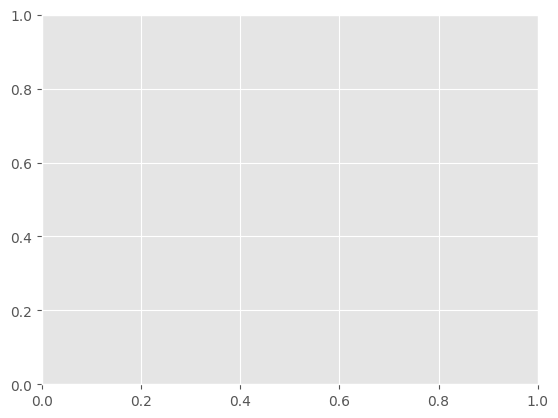

In [8]:
config = EcgConfig()
trainer = ECGClassifierTrainer(config)

train_confusion_matrix, eval_confusion_matrix, epoch_loss = trainer.train()

## Evaluating

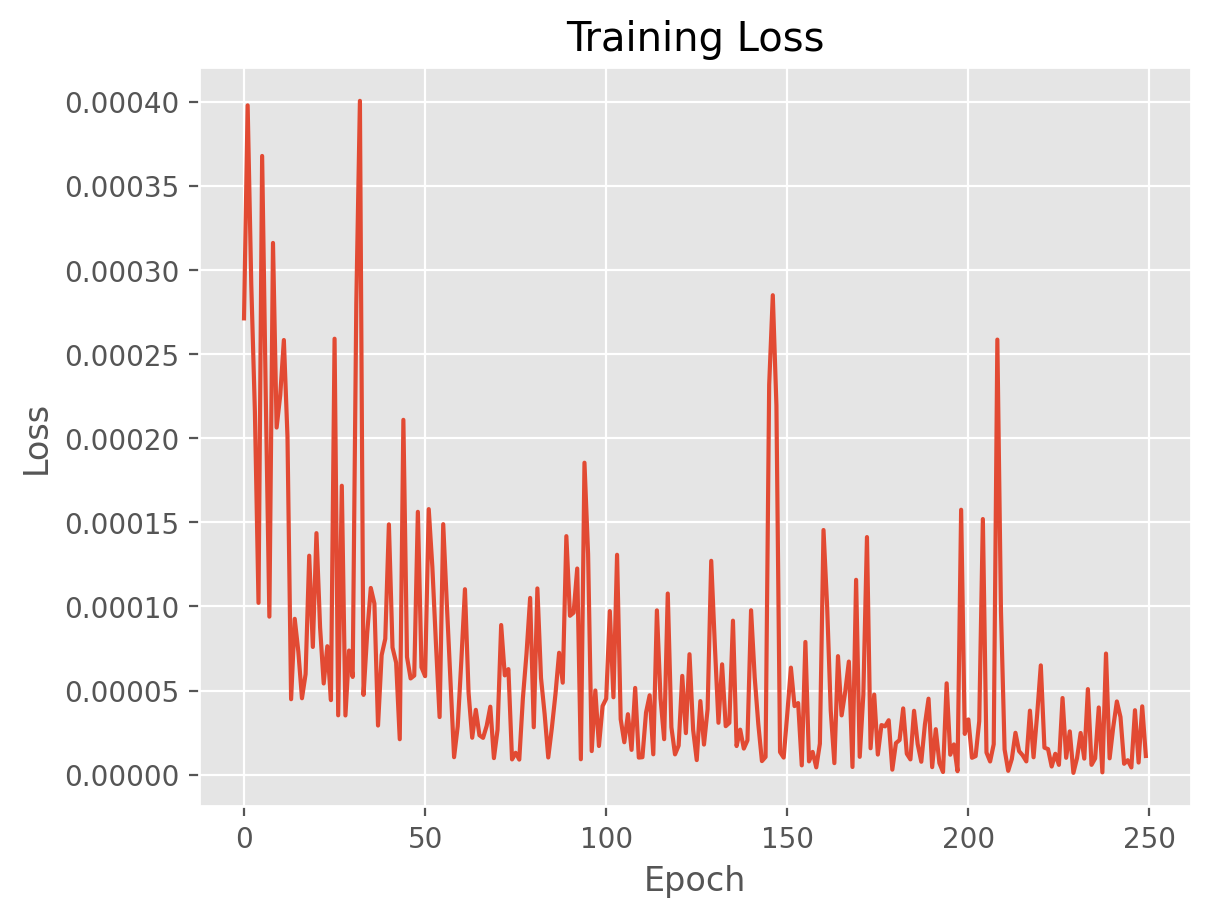

In [9]:
# plot loss
plt.figure(1, dpi=200)
plt.plot(epoch_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
%matplotlib inline
plt.show()

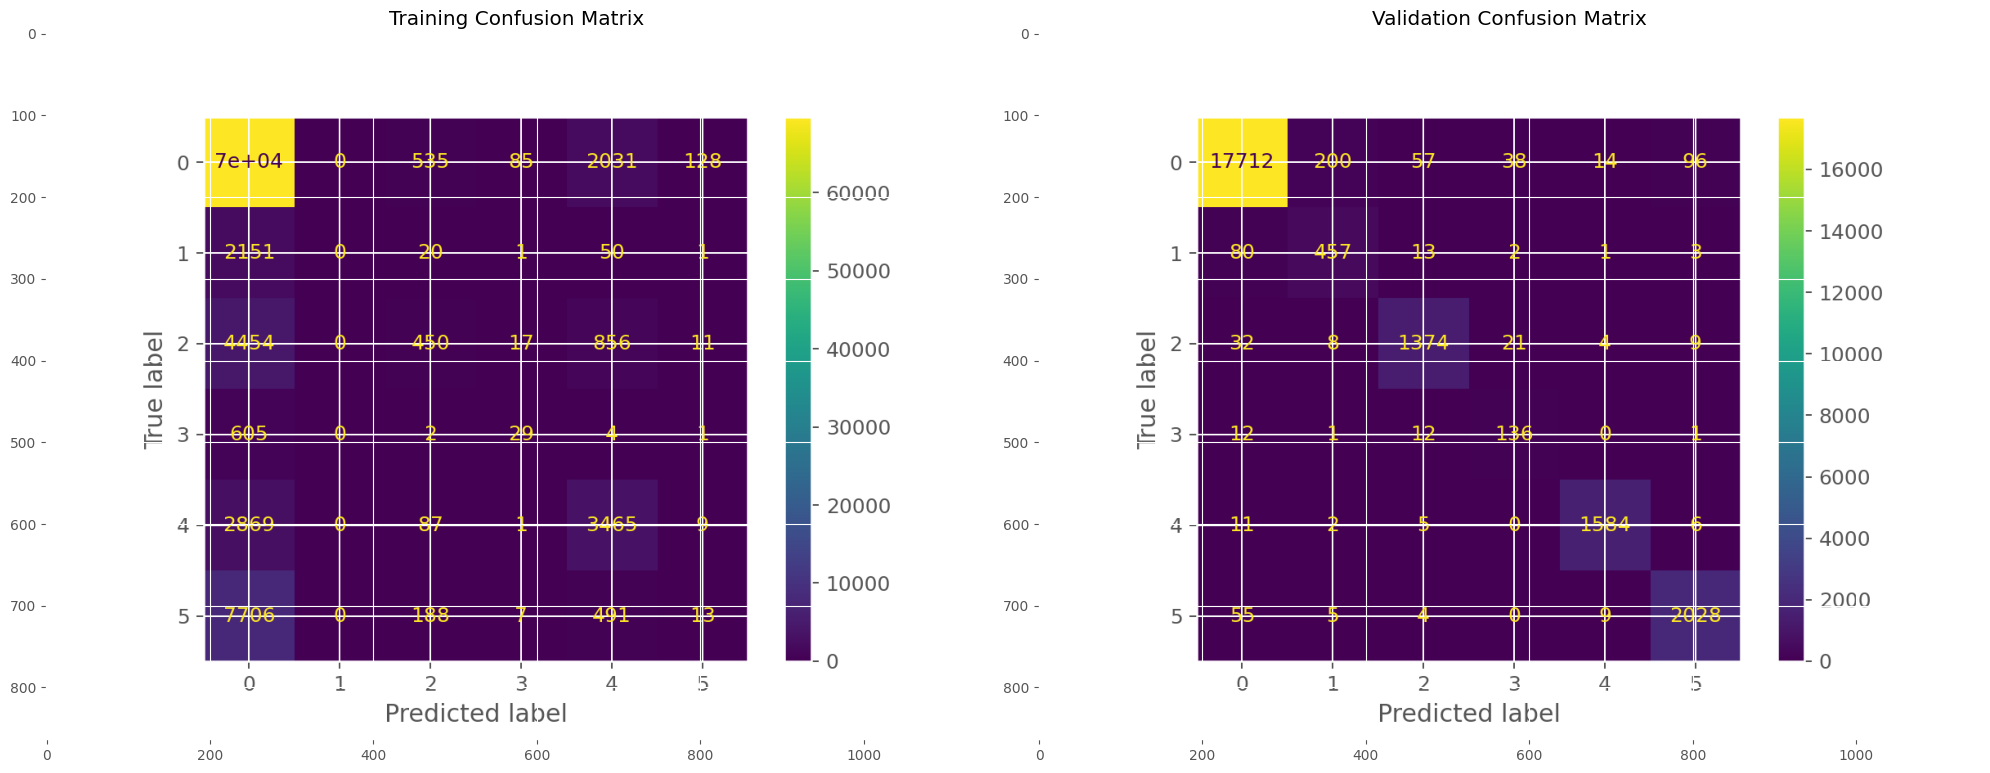

In [10]:
# Confusion matrix
plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.imshow(train_confusion_matrix[0])
plt.title("Training Confusion Matrix")


plt.subplot(1, 2, 2)
plt.imshow(eval_confusion_matrix[-1])
plt.title("Validation Confusion Matrix")

plt.tight_layout()
plt.show()


## Save model and load model

In [11]:
import torch
torch.save(model, "..\\model_save\\model.pth")
model_test = torch.load("..\\model_save\\model.pth")
print(model_test)

ECGformer(
  (encoder): ModuleList(
    (0-3): 4 x TransformerEncoderLayer(
      (0): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (queries_projection): Linear(in_features=192, out_features=192, bias=True)
            (values_projection): Linear(in_features=192, out_features=192, bias=True)
            (keys_projection): Linear(in_features=192, out_features=192, bias=True)
            (final_projection): Linear(in_features=192, out_features=192, bias=True)
          )
          (2): Dropout(p=0.1, inplace=False)
        )
      )
      (1): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (1): MLP(
            (0): Linear(in_features=192, out_features=768, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=768, out_features=192, bias=True)
          )
          (2):

In [12]:
import torch.quantization
model(torch.randn(1, config.model.signal_length, 1)).shape

# 使用 Eager Mode Quantization
# 將 torch.nn.Linear 的參數映射到 -127~127 之間
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)
torch.save(quantized_model, "..\\model_save\\model_quantized.pth")
model_test = torch.load("..\\model_save\\model_quantized.pth")

print(model_test)


ECGformer(
  (encoder): ModuleList(
    (0-3): 4 x TransformerEncoderLayer(
      (0): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (queries_projection): DynamicQuantizedLinear(in_features=192, out_features=192, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (values_projection): DynamicQuantizedLinear(in_features=192, out_features=192, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (keys_projection): DynamicQuantizedLinear(in_features=192, out_features=192, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
            (final_projection): DynamicQuantizedLinear(in_features=192, out_features=192, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
          )
          (2): Dropout(p=0.1, inplace=False)
        )
      )
      (1): ResidualAdd(
        (block): Sequential(
          (0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)


C:\Users\Chen_Lab01\anaconda3\envs\pytorch-ecg\lib\site-packages\torch\_utils.py:383: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


In [13]:
import einops
loader = get_data_loaders(DatasetConfig())
accuracy = 0
for signal, label in loader[Mode.eval]:
    p = model_test(einops.rearrange(signal, "b c e -> b e c"))
    print(p)
    print(label)
    # print(signal.shape, label.shape)
    print(p.argmax(1) == label)
    accuracy += torch.sum(p.argmax(1) == label)
    print(f"accuracy: {accuracy / config.dataset.batch_size}")
    break



tensor([[-0.4207, -0.5847, -0.0477,  0.8674, -0.2809, -0.7447],
        [-0.4701, -0.5728, -0.0848,  0.8721, -0.3571, -0.7432],
        [-0.4322, -0.5873, -0.0519,  0.8650, -0.3234, -0.7514],
        [-0.4210, -0.5766, -0.0381,  0.8344, -0.2656, -0.7673],
        [-0.4714, -0.5762, -0.0656,  0.8990, -0.3861, -0.7257],
        [-0.5083, -0.5554, -0.0802,  0.9041, -0.4220, -0.7192],
        [-0.3525, -0.5885, -0.0398,  0.8082, -0.2103, -0.7616],
        [-0.4023, -0.5704, -0.0497,  0.8315, -0.2758, -0.7701],
        [-0.3832, -0.5929, -0.0370,  0.8318, -0.2400, -0.7570],
        [-0.4788, -0.5673, -0.0898,  0.8909, -0.3771, -0.7423],
        [-0.4761, -0.5876, -0.0774,  0.8969, -0.3836, -0.7364],
        [-0.4685, -0.5801, -0.0809,  0.8848, -0.3533, -0.7523],
        [-0.3745, -0.6013, -0.0204,  0.8162, -0.2204, -0.7570],
        [-0.4785, -0.5855, -0.0879,  0.8734, -0.3540, -0.7425],
        [-0.4712, -0.5803, -0.0809,  0.8551, -0.3477, -0.7465],
        [-0.4481, -0.5871, -0.0424,  0.8

## Parameter 提取

In [14]:
for name in model_test.state_dict():
   print(name)

print(quantized_model.state_dict()['encoder.0.0.block.1.queries_projection._packed_params._packed_params'])

positional_encoding
encoder.0.0.block.0.weight
encoder.0.0.block.0.bias
encoder.0.0.block.1.queries_projection.scale
encoder.0.0.block.1.queries_projection.zero_point
encoder.0.0.block.1.queries_projection._packed_params.dtype
encoder.0.0.block.1.queries_projection._packed_params._packed_params
encoder.0.0.block.1.values_projection.scale
encoder.0.0.block.1.values_projection.zero_point
encoder.0.0.block.1.values_projection._packed_params.dtype
encoder.0.0.block.1.values_projection._packed_params._packed_params
encoder.0.0.block.1.keys_projection.scale
encoder.0.0.block.1.keys_projection.zero_point
encoder.0.0.block.1.keys_projection._packed_params.dtype
encoder.0.0.block.1.keys_projection._packed_params._packed_params
encoder.0.0.block.1.final_projection.scale
encoder.0.0.block.1.final_projection.zero_point
encoder.0.0.block.1.final_projection._packed_params.dtype
encoder.0.0.block.1.final_projection._packed_params._packed_params
encoder.0.1.block.0.weight
encoder.0.1.block.0.bias
enco